In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from src.utils.helpers import set_random_seed
set_random_seed()

# Data

## Data Loading

In [3]:
from src.data import download_data

In [4]:
download_data(force_download=False)

## Data Analysis and Cleaning

In [5]:
from src.data import load_characters, load_movies, load_movies_and_plots, load_plots
# load all tables
movies = load_movies()
characters = load_characters()
plots = load_plots()

In [6]:
show_amount = 2

print(f"Movie Metadata of shape {movies.shape}:")
display(movies.head(show_amount))

print(f"\nCharacter Metadata of shape {characters.shape}:")
display(characters.head(show_amount))

print(f"\nPlot Summaries of shape {plots.shape}:")
display(plots.head(show_amount))

Movie Metadata of shape (81741, 9):


WikipediaId FreebaseId                                          MovieName  \
0       975900  /m/03vyhn                                     Ghosts of Mars   
1      3196793  /m/08yl5d  Getting Away with Murder: The JonBenét Ramsey ...   

  ReleaseDate     Revenue  Runtime                           Languages  \
0  2001-08-24  14010832.0     98.0  {"/m/02h40lc": "English Language"}   
1  2000-02-16         NaN     95.0  {"/m/02h40lc": "English Language"}   

                                   Countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   

                                              Genres  
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...  
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...


Character Metadata of shape (450669, 13):


WikipediaId FreebaseId ReleaseDate               CharacterName  \
0       975900  /m/03vyhn  2001-08-24                    Akooshay   
1       975900  /m/03vyhn  2001-08-24  Lieutenant Melanie Ballard   

  ActorDateOfBirth ActorGender  ActorHeight ActorEthnicity  \
0       1958-08-26           F         1.62            NaN   
1       1974-08-15           F         1.78     /m/044038p   

            ActorName  ActorAgeAtRelease FreebaseCharacterActorMapId  \
0      Wanda De Jesus               42.0                  /m/0bgchxw   
1  Natasha Henstridge               27.0                   /m/0jys3m   

  FreebaseCharId FreebaseActorId  
0     /m/0bgcj3x      /m/03wcfv7  
1     /m/0bgchn4       /m/0346l4


Plot Summaries of shape (42303, 2):


WikipediaId                                        PlotSummary
0     23890098  Shlykov, a hard-working taxi driver and Lyosha...
1     31186339  The nation of Panem consists of a wealthy Capi...

Now we focus on identifying and handling missing values within the CMU Movie Summary dataset. We will inspect missing values in the `movies` and `characters` tables, visualize the distribution of missing data and drop the rows with missing information.

To understand where the data is incomplete, we will calculate the number of missing values for each column in the `movies` and `characters` tables. As we are not using `plots` in the current plan, we are not making any analysis related to them.

At first, let's analyse the `movies` table:

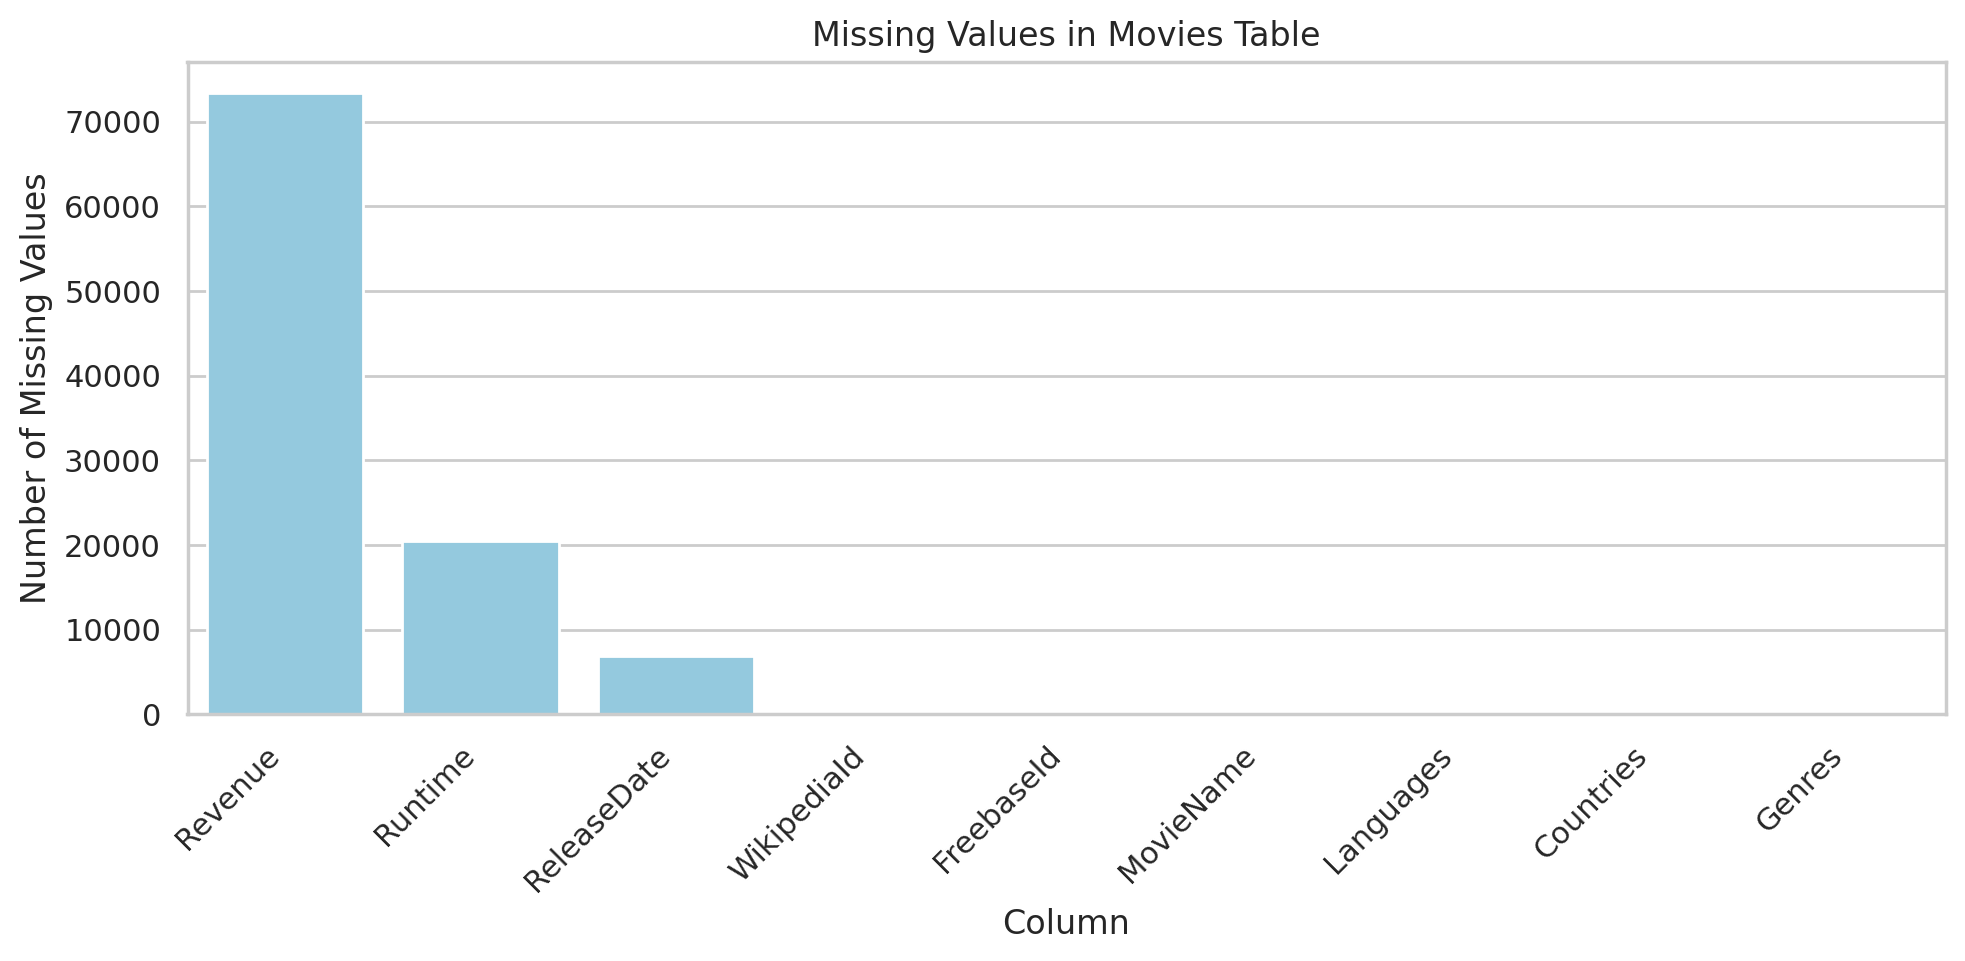

In [7]:
from src.utils.helpers import plot_nan_distribution

plot_nan_distribution(movies, table_name="Movies")

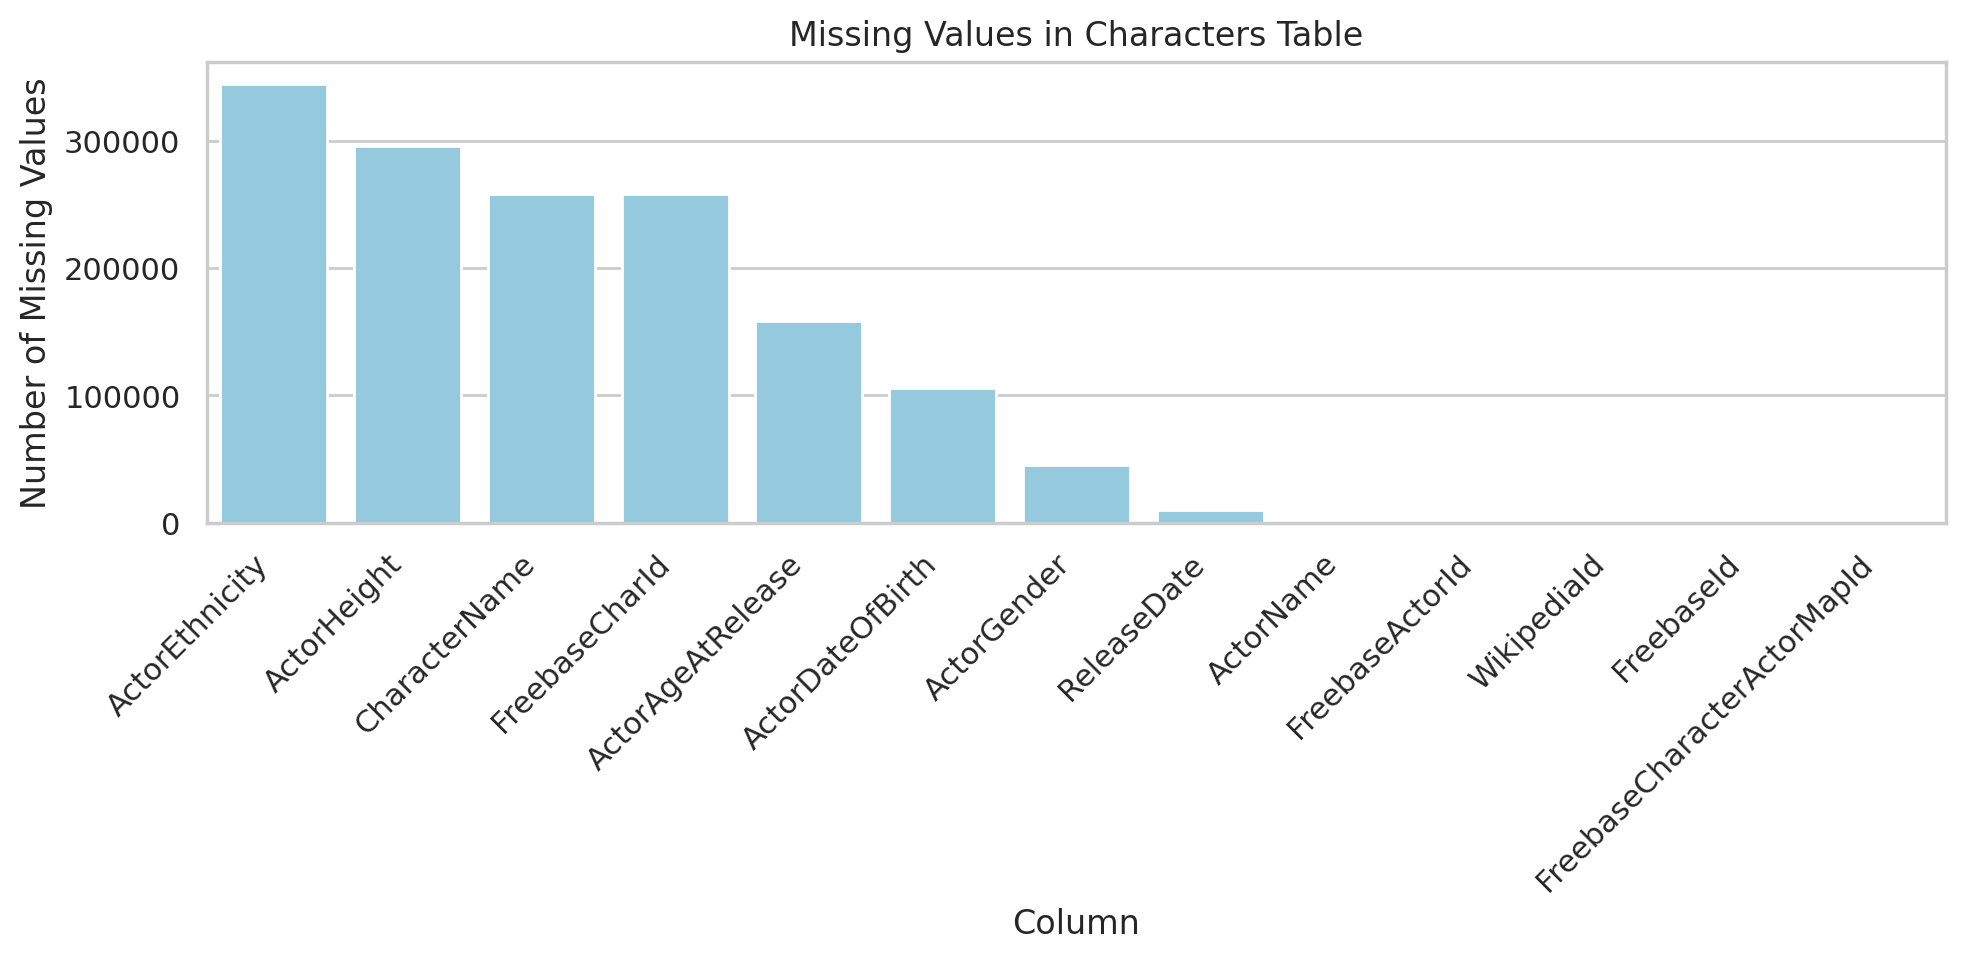

In [8]:
plot_nan_distribution(characters, table_name="Characters")

In [9]:
plot_nan_distribution(plots, table_name="Plots")

There is no Nans in Plots


We see that there are a lot of Nans, but, as described in the README, we want to focus on USA movies. We filter the dataset to get movies produced in the USA (i.e., has USA in the "Countries" column).

In [10]:
from src.utils.helpers import filter_by_country
us_movies = filter_by_country(movies, country="United States of America")
print("Number of US movies:", us_movies.shape[0])

Number of US movies: 34408


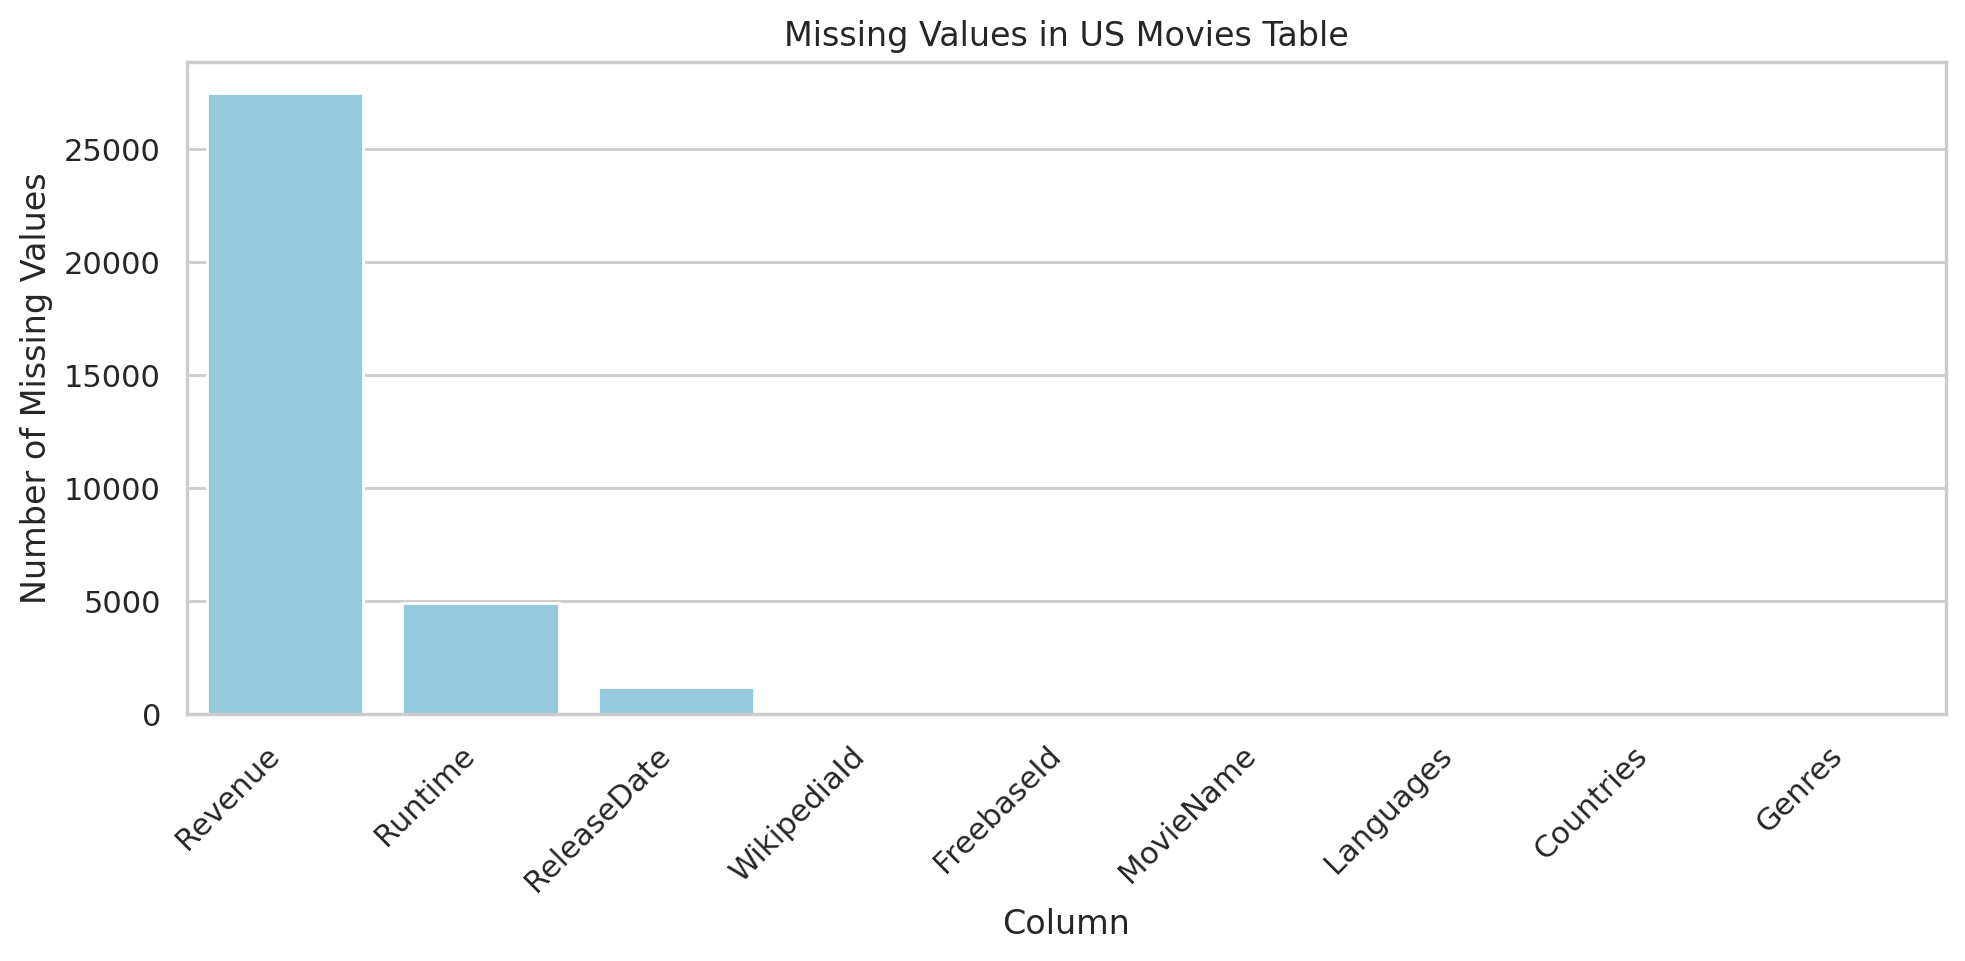

In [11]:
plot_nan_distribution(us_movies, table_name="US Movies")

As revenue is a core part of our analysis, we will drop the rows with missing revenue. We also want to investigate how clusters change in time, so we need the date information too and, therefore, keep only the non-Nan rows.

We also noticed that the ReleaseDate format is not fixed, so we change all values to a common format. 

In [12]:
from src.utils.helpers import drop_nans, fix_date

us_movies = drop_nans(us_movies, column="Revenue")
us_movies = drop_nans(us_movies, column="ReleaseDate")
us_movies = fix_date(us_movies, column="ReleaseDate")
print("Number of US movies after dropping Nans:", us_movies.shape[0])

Number of US movies after dropping Nans: 6923


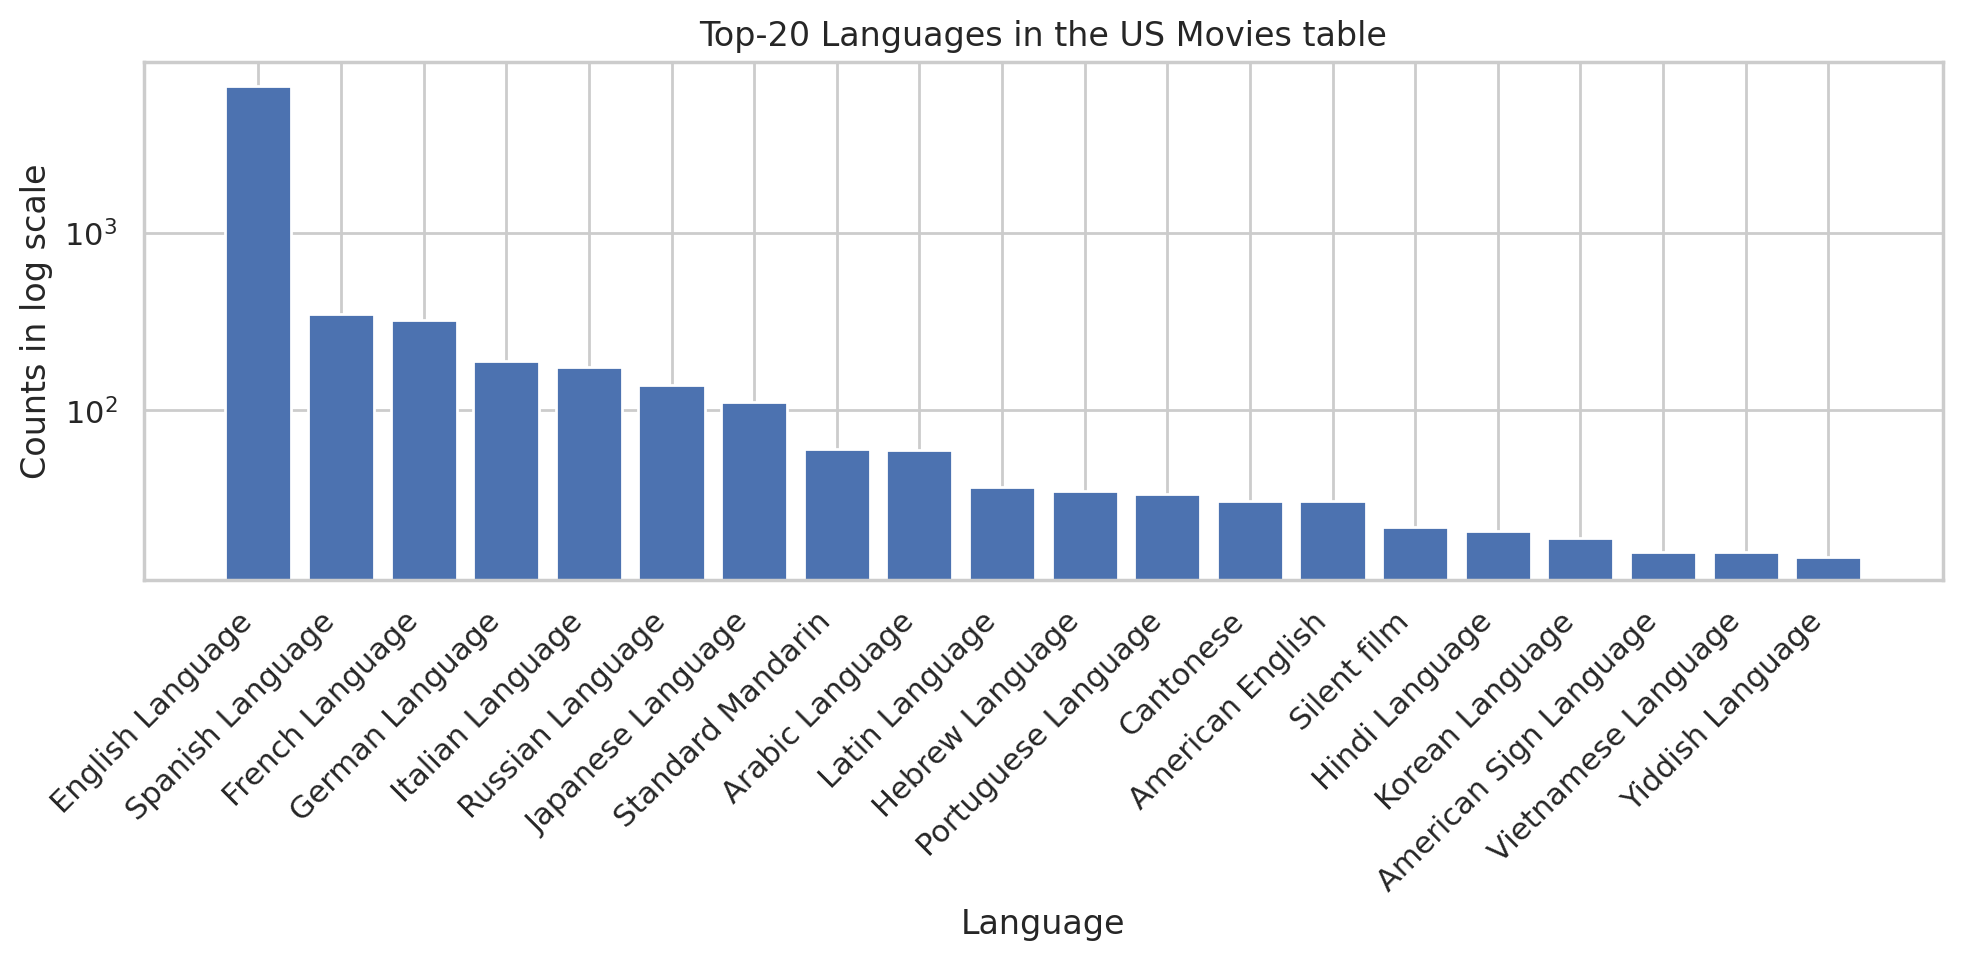

The top-1 language is in 97.91% of the movies


In [13]:
from src.utils.helpers import get_language_distribution
get_language_distribution(us_movies, table_name="US Movies", limit=20)

We see that English language is in $97.91\%$ of the movies. This, together with the plot, means that movies with other languages may be outliers for our analysis and bias the results. Thus, we remove movies that are not in English.

In [14]:
from src.utils.helpers import filter_by_language
us_movies = filter_by_language(us_movies, language="English Language")

Let's see the temporal distribution of our data after filtering.

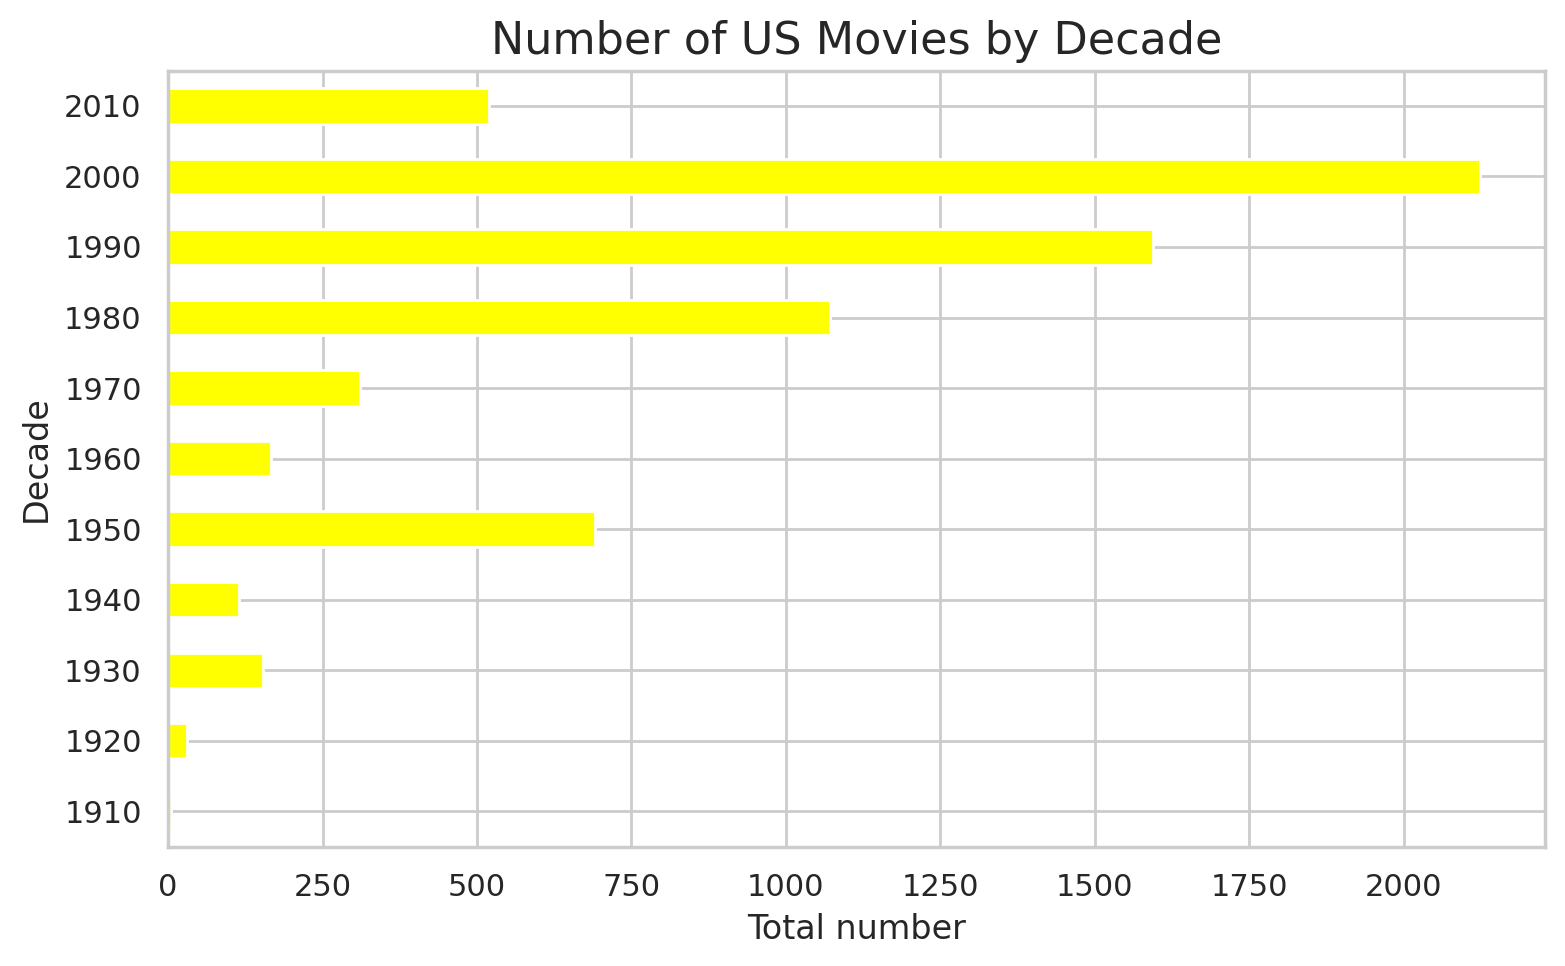

In [15]:
from src.utils.helpers import plot_decade_distribution
plot_decade_distribution(us_movies, table_name="US Movies")

Let's look at the revenue distribution:

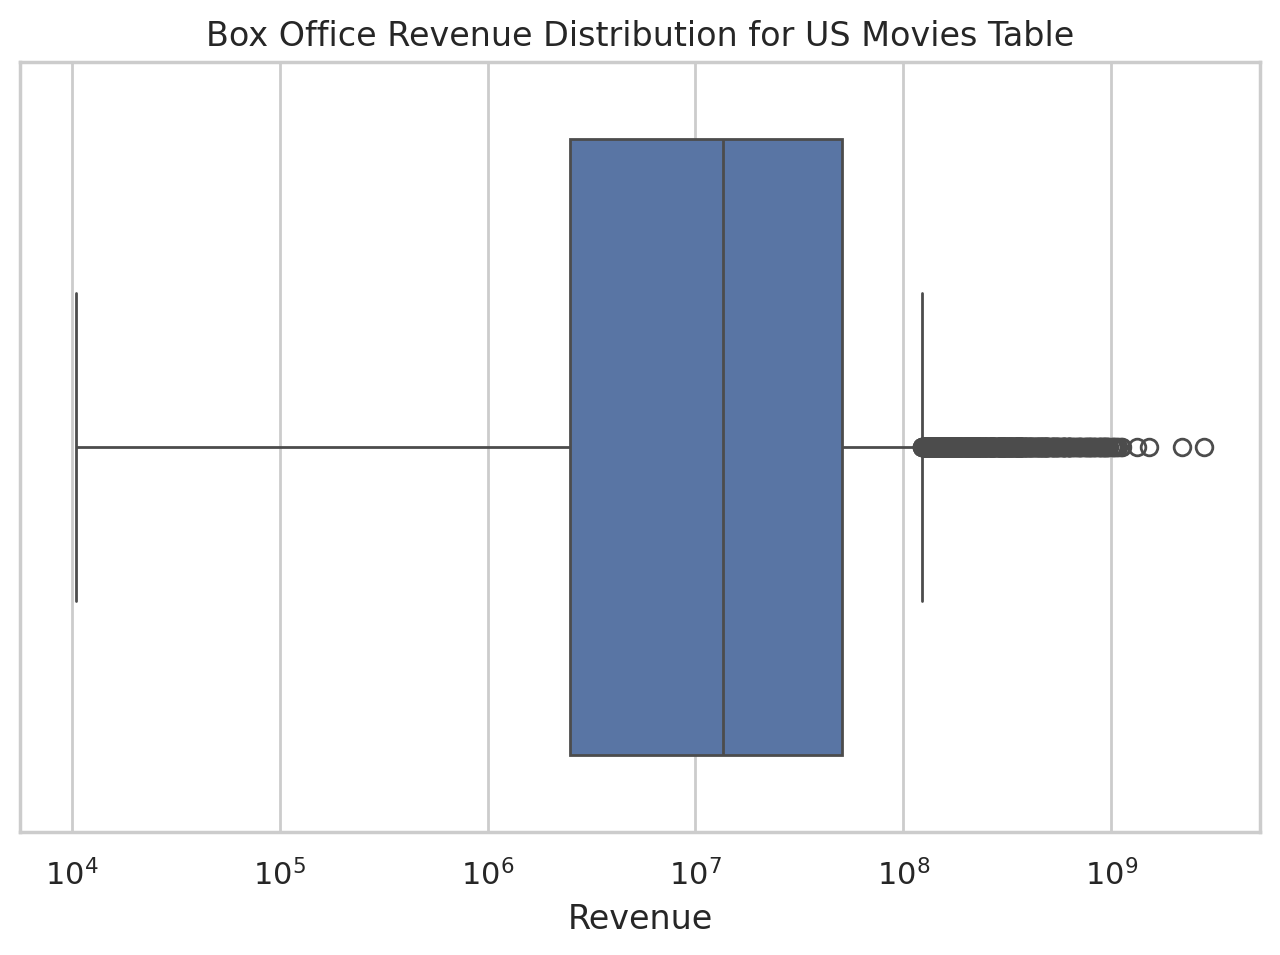

In [16]:
from src.utils.helpers import plot_revenue_distribution

plot_revenue_distribution(us_movies, table_name="US Movies")

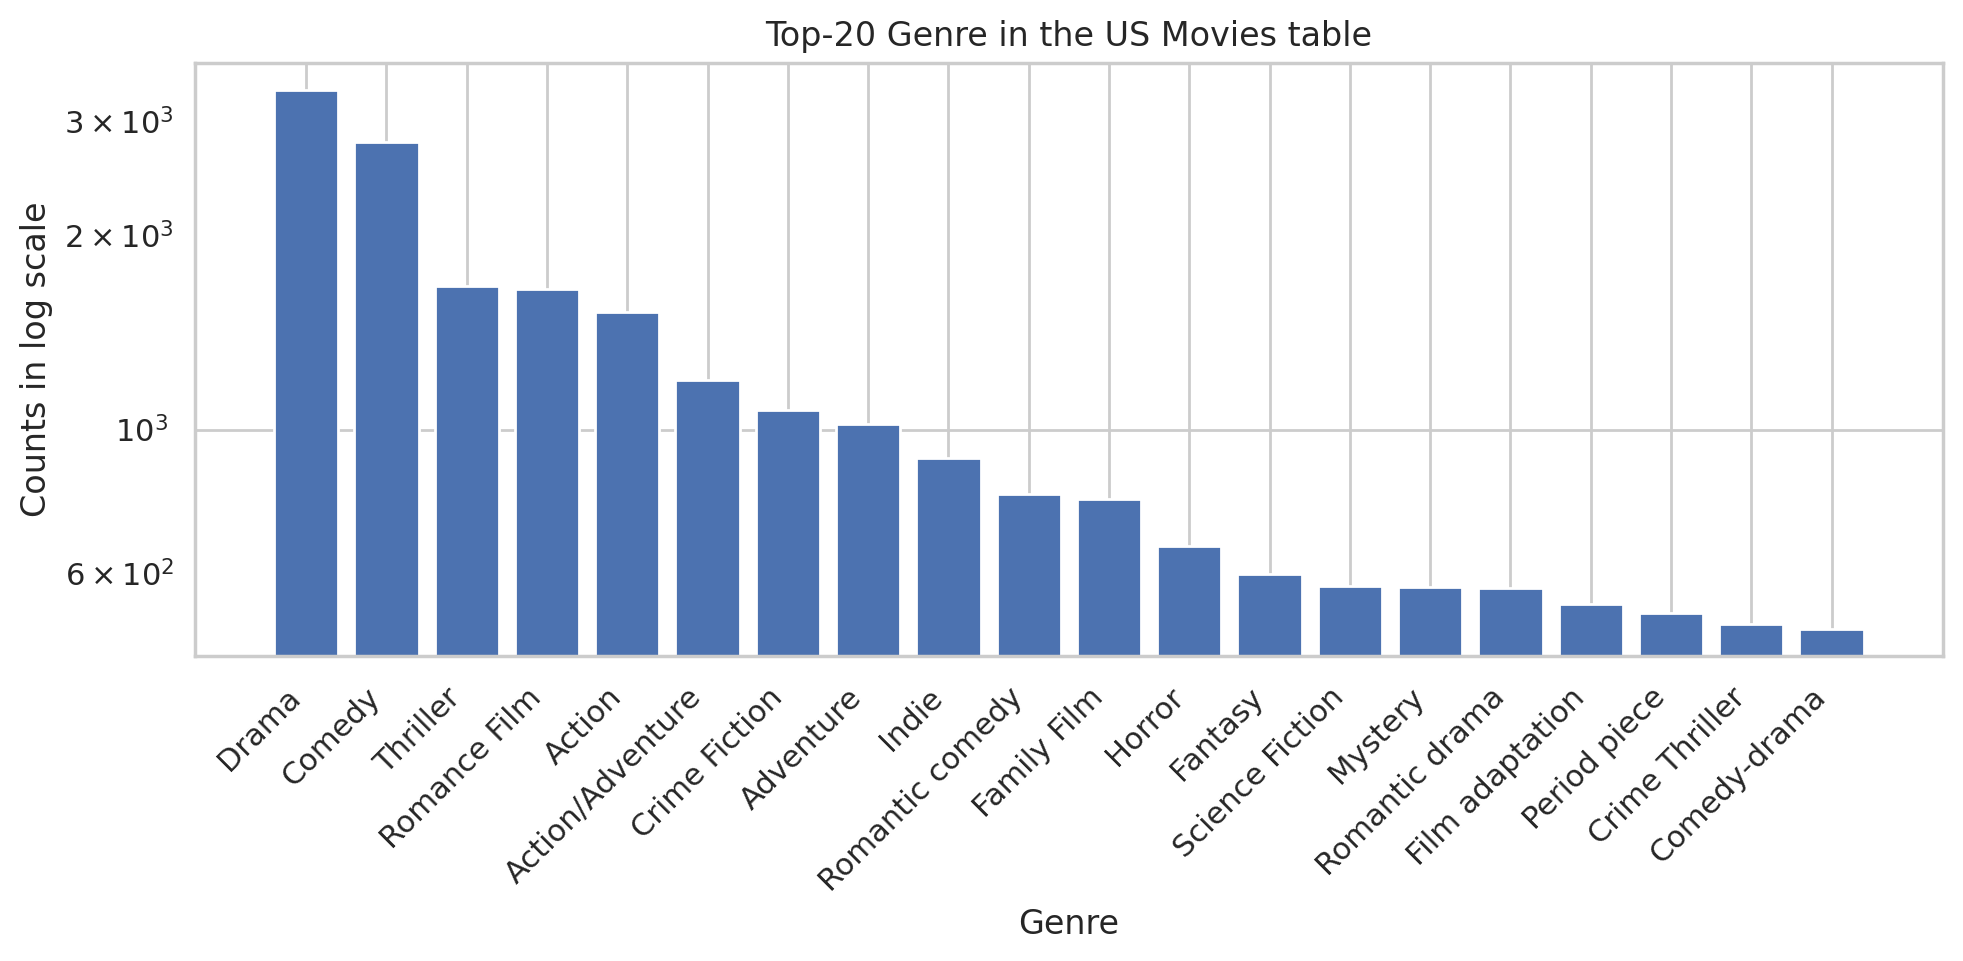

In [17]:
from src.utils.helpers import plot_top_genres

plot_top_genres(us_movies, table_name="US Movies", limit=20)

### Characters

Now, let's move to `characters` table (also referred as `actors`). We already saw that there are some Nans

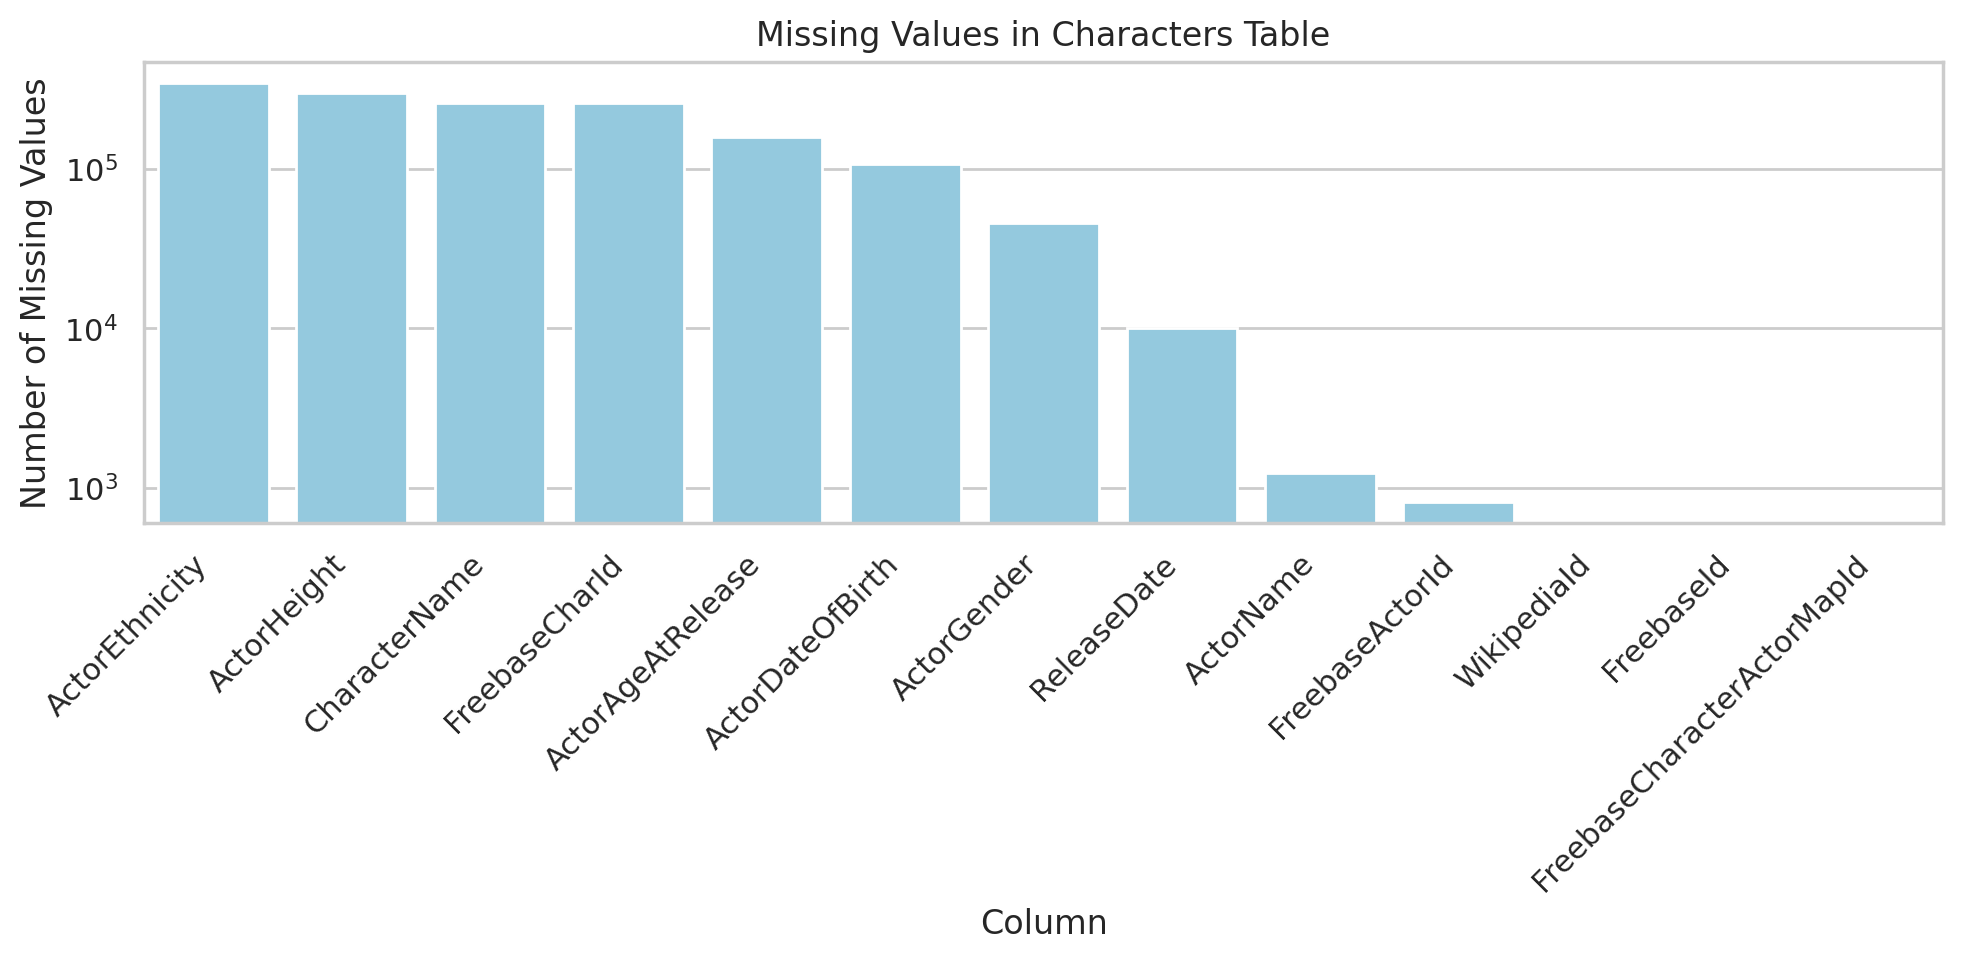

In [18]:
plot_nan_distribution(characters, table_name="Characters", log_scale=True)

This time we plotted it with a log-scale Y-axis and saw that actually some of the `FreebaseActorId` are Nan. We should drop such rows because we cannot create a graph without knowing actors. We are not touching other columns because we are not utilizing them in the current analysis.

In [19]:
characters = drop_nans(characters, column="FreebaseActorId")

Let's do some statistical analysis

In [20]:
from src.utils.actors import ActorStats

actor_stats = ActorStats(characters=characters, movies=us_movies)

At first, let's look at the statistics for a specific actor. For example, `/m/0c0k1` (Harrison Ford)

In [21]:
actor_id = "/m/0c0k1"
actor_stats.actor_name(actor_id)

'Harrison Ford'

In [22]:
actor_stats.actor_movies(actor_id).head(2)

WikipediaId FreebaseId              MovieName ReleaseDate      Revenue  \
1983        43307   /m/0bw20   K-19: The Widowmaker  2002-07-19   65716126.0   
2637       365039  /m/01_wsl  Six Days Seven Nights  1998-06-12  164839294.0   

      Runtime                                          Languages  \
1983    138.0  {"/m/06b_j": "Russian Language", "/m/02h40lc":...   
2637    102.0  {"/m/04306rv": "German Language", "/m/02h40lc"...   

                                              Countries  \
1983  {"/m/09c7w0": "United States of America", "/m/...   
2637          {"/m/09c7w0": "United States of America"}   

                                                 Genres  Year  Decade  
1983  {"/m/01jfsb": "Thriller", "/m/0cq22f9": "Actio...  2002    2000  
2637  {"/m/06cvj": "Romantic comedy", "/m/03k9fj": "...  1998    1990

In [23]:
actor_stats.actor_prefered_genres(actor_id, n=4)

[('Drama', 23), ('Action', 17), ('Thriller', 15), ('Action/Adventure', 12)]

In [24]:
actor_stats.print_actor_stats(actor_id)

Name: Harrison Ford
  * Played in 35 movies.
  * Favourite genre: Drama (23 movies).
  * Total movie revenues:    6,397,871,819$.
  * Average movie revenue:     182,796,338$.


Our primary goal is to analyze clusters as described in the README. But before going into the cluster analysis, let's look at the whole picture by assigning all actors (participated in the `us_movies`) to a single cluster. This allows us to use the same functions without copy-pasting the code.

In [25]:
from src.utils.helpers import merge_movies_and_actors

us_characters_movies = merge_movies_and_actors(us_movies, characters)
# note that there might be movies without actors information
print("Total number of movies after merge:", us_characters_movies.groupby("WikipediaId").size().shape[0])

Total number of movies after merge: 6693


In [26]:
us_actors = us_characters_movies.FreebaseActorId.unique()
print("Total number of actors in the US movies:", us_actors.shape[0])

Total number of actors in the US movies: 30378


In [27]:
# create a single cluster of all us actors for the full analysis
from src.utils.actors import Cluster

full_cluster = Cluster(characters=characters, movies=us_movies, actor_ids=us_actors)

In [28]:
full_cluster.cluster_mean_revenue()

67705066.10700375

In [29]:
full_cluster.cluster_total_revenue()

374115470742.0

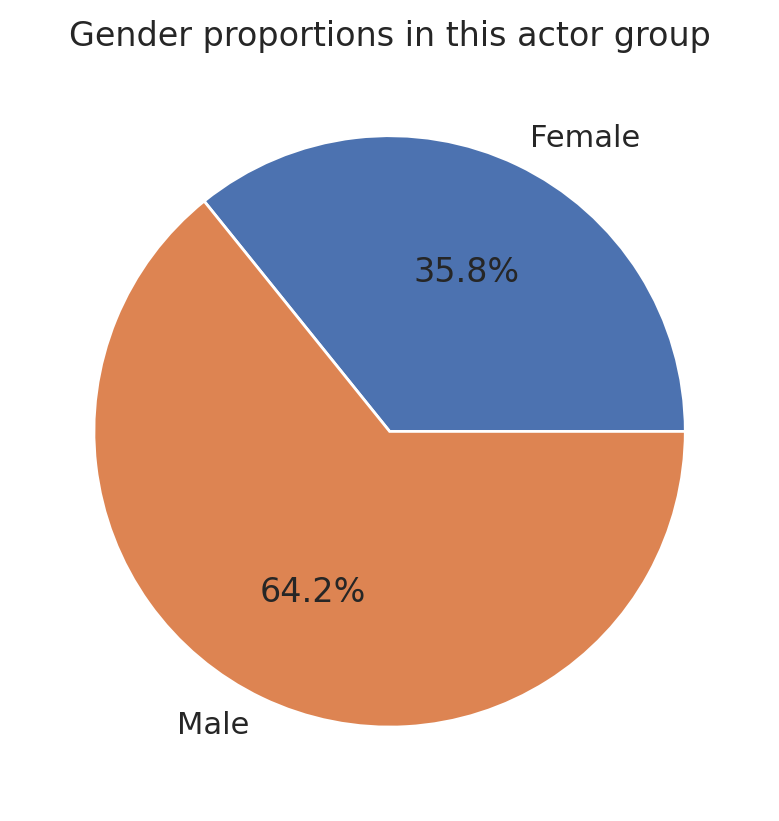

In [30]:
_ = full_cluster.cluster_genders(plot=True)

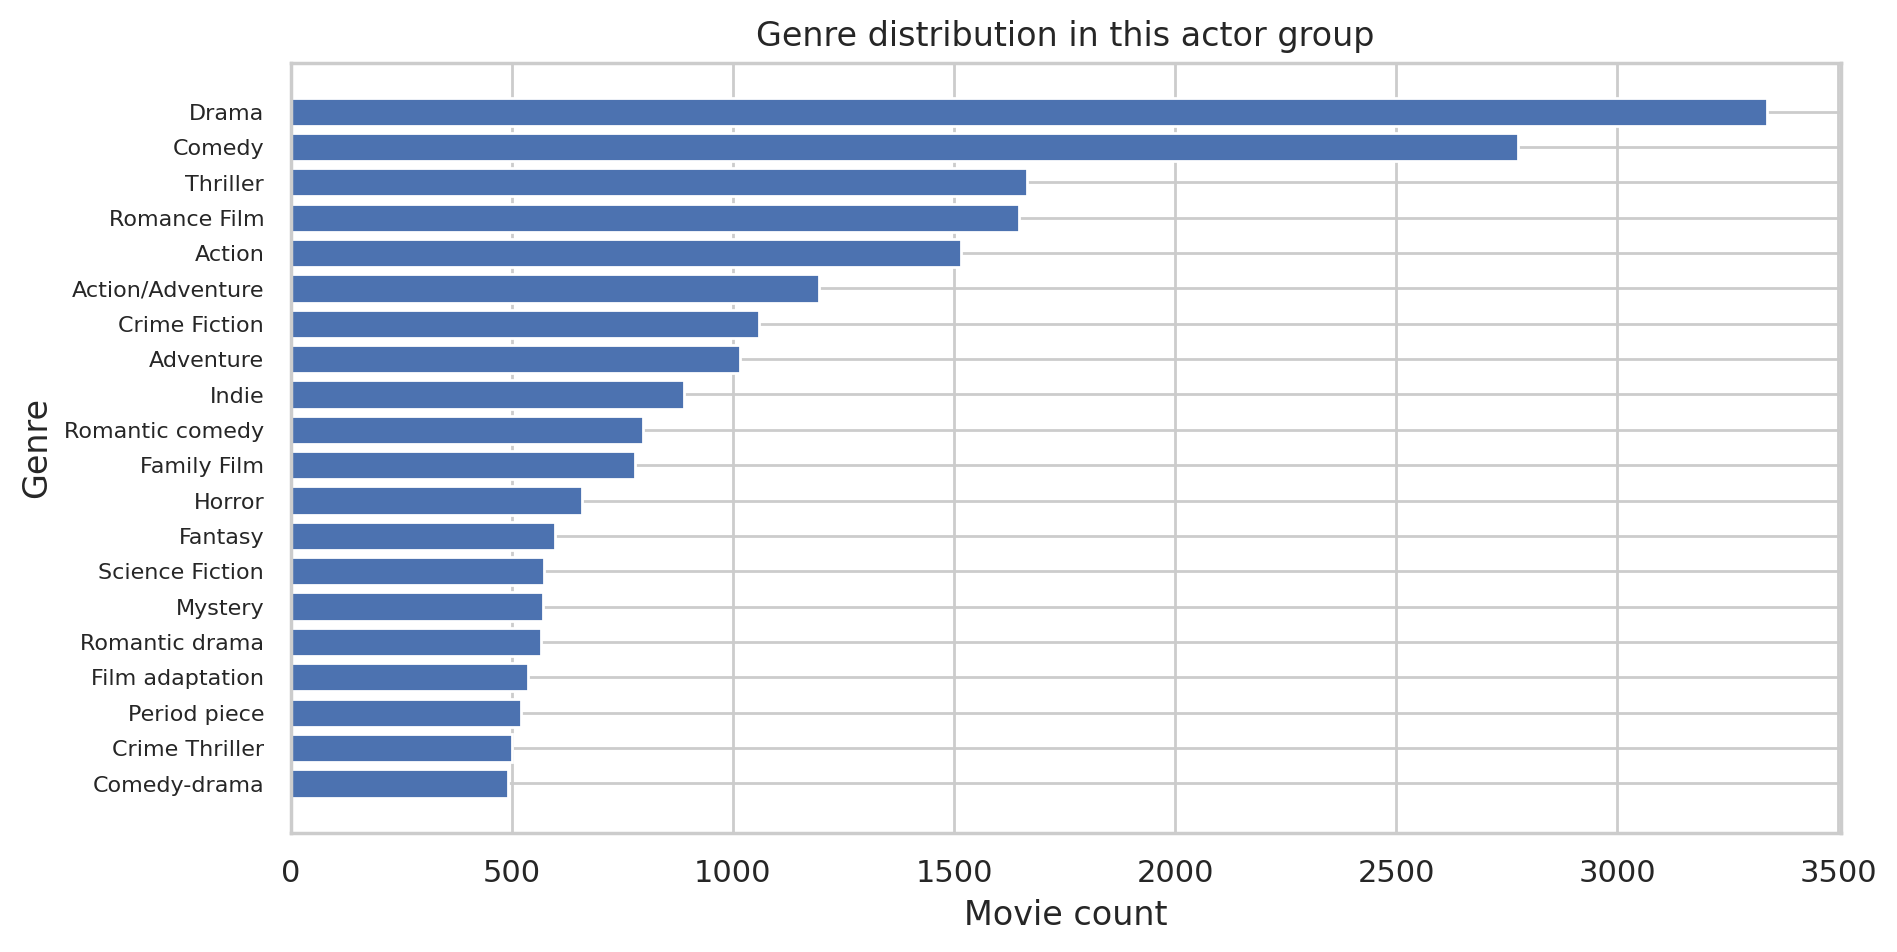

In [31]:
_ = full_cluster.cluster_genres(plot=True)

# Partitioning 

In this section, we define the "friendship" graph: actors are used as vertices and two actors are "friends" (i.e., have an edge connecting them) if they have a mutual movie.

In [32]:
import networkx as nx
from src.utils.helpers import create_graph_from_data

G_US = create_graph_from_data(us_characters_movies)
print(f"Number of vertices: {len(G_US.nodes)}, number of edges: {len(G_US.edges)}")

Number of vertices: 30378, number of edges: 613672


In [33]:
from src.utils.helpers import get_connected_components
connected_component_sizes = sorted(map(len, get_connected_components(G_US)), reverse=True)
print(f"Number of components: {len(connected_component_sizes)}, sizes of top-5 components: {connected_component_sizes[:5]} ")

Number of components: 70, sizes of top-5 components: [30005, 18, 18, 17, 16] 


In [34]:
30005 / 30378 * 100

98.77213773125288

We see that we cannot use connected components as meaningful clusters because $\frac{30005}{30378} \cdot 100\% \simeq 98.8\%$ of the actors are in one of them, while other components have less than $0.06\%$ each. So we use [Louvain Community Detection algorithm](https://github.com/taynaud/python-louvain), described in the README.

In [35]:
from src.utils.helpers import get_communities
from src.data import ROOT_PATH
set_random_seed() # to enhance reproducibility

processed_dir = ROOT_PATH / "data" / "processed"
processed_dir.mkdir(exist_ok=True, parents=True)

In [40]:
# ### we commented this cell because we saved the communities into a json

# from src.utils.helpers import get_communities, write_communities

# for communities_seed in range(1, 6):
#     # to enhance reproducibility **between** machines, we save communities and push them on Git
#     communities_US = get_communities(G_US, seed=communities_seed) # takes some time

#     write_communities(G_US, communities_US, fname=str(processed_dir / f"new_communities_US_{communities_seed}.json"))

In [36]:
from src.utils.helpers import read_communities

communities_US = read_communities(G_US, str(processed_dir / "new_communities_US_1.json"))

In [37]:
community_sizes = sorted(map(len, communities_US), reverse=True)
print(f"Number of communities: {len(communities_US)}, sizes of top-5 communities: {community_sizes[:5]} ")

Number of communities: 133, sizes of top-5 communities: [6332, 5748, 4505, 3979, 1655] 


TODO add plot with graph visualization

## Verification of clusters quality

To ensure that our partitioning is reasonable, we conduct some sanity check experiments. In this one, we assign a cluster for each movie: if more than $50\%$ of the movie actors are inside cluster `SomeName`, we assign this cluster `SomeName` to the movie. Note that some movies may not have any cluster assigned after this operation (if, for example, its actors are evenly spread across more than 2 clusters).

Then, for each cluster, we investigate the distribution of the release year for its movies (movies assigned to this cluster). We assume that a good clustering algorithm should combine actors that participated in the movies of roughly the same time period. This is reasonable as actors become old and is unlikely that the actor who played in the 1940's will also appear in 2010's movies, for example. Or, for instance, Stallone, Schwarzenegger, and Lundgren are well-known actors of old-school action-movies and it would be reasonable for them to be in one cluster. While, for instance, The Rock, Hardy, and Gosling are more modern acion-movies actors and probably should be in another cluster. This said, we assume the calculated distribution of movies actors to be compact.

In [43]:
from src.utils.helpers import calculate_partition_quality

df_parition_top_movie_info = calculate_partition_quality(G=G_US, communities=communities_US,
                                                         movies=us_movies,
                                                         characters_movies=us_characters_movies,
                                                         take_film_fraction=0.5)

The performance (partition quality) metric is 0.876074229844255
The coverage (partition quality) metric is 0.6190342723800336


We also calculated the `networkx` partition quality metrics $\in [0,1]$. The "coverage" metric measures the ratio of number of the edges that are inside partitions to the total number of edges. If this number is close to 1, it means that the algorithm works like "connected component" approach, which is bad (when you have extremely large components), as we discussed above. If this number is close to 0, it means that the clusters are extremely small, which hurts the analysis and conclusions. For our choice of the algorithm, the metric is good. The "performance" metrics calculates the ratio of the sum of the number of edges inside the clusters and the number of non-edges (if two vertices do not have an edge, we say this is a non-edge) between the clusters to the total number of possible edges ($\frac{n(n-1)}{2}$ for the graph with $n$ vertices). See more in [this paper](https://arxiv.org/abs/0906.0612).

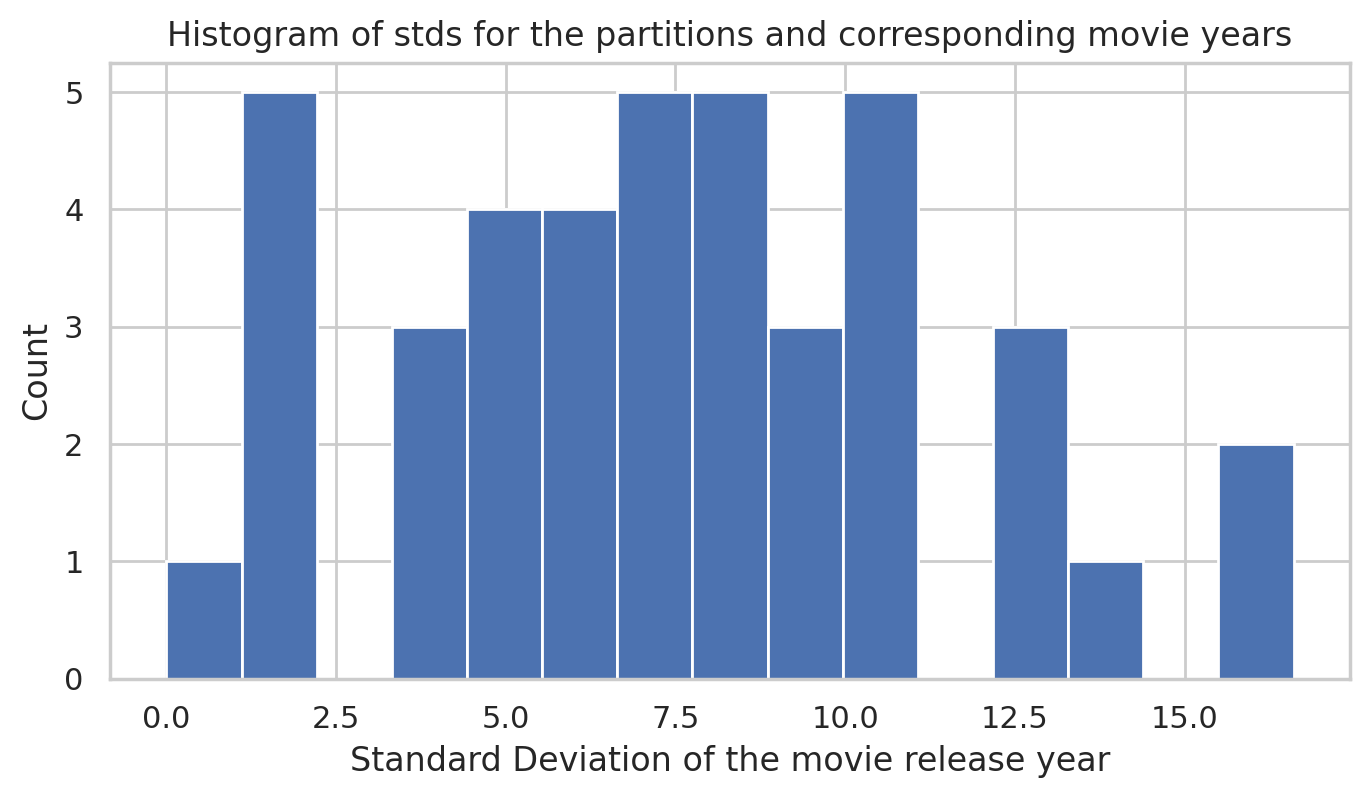

In [44]:
from src.utils.helpers import plot_partition_year_std_distribution

plot_partition_year_std_distribution(df_parition_top_movie_info)

We see that mostly the std is around $8$ years which sounds reasonable enough, given that we have a long time range of movies in the dataset (from 1910s to 2010s, i.e. a range of 100 years)

Now, we will work with our Graph wrapper for stats calculation

In [45]:
from src.utils.graphs import Graph

graph_stats = Graph.init_from_list_of_lists(characters=characters,
                                            movies=us_movies,
                                            communities=communities_US)

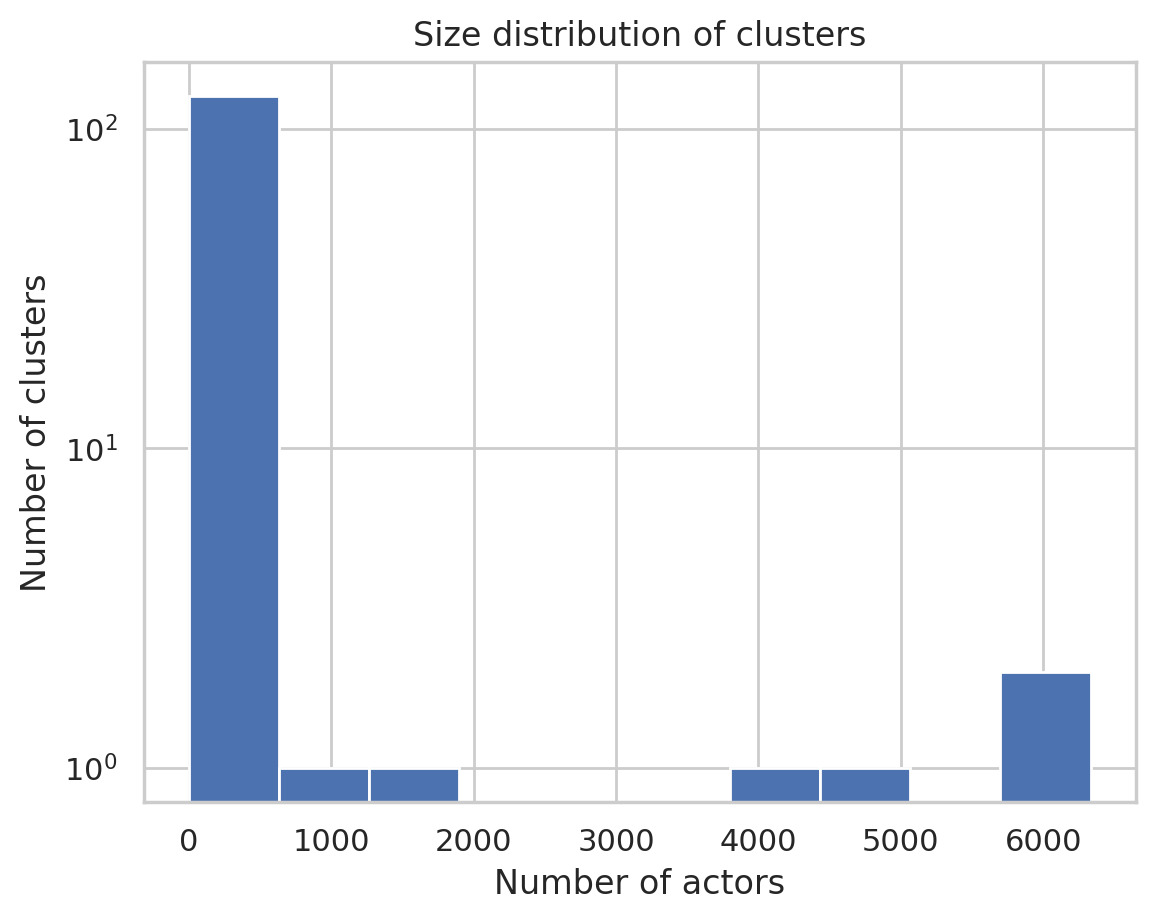

In [46]:
_ = graph_stats.size_distribution(plot=True, log=True)

As we also saw previously, the top-5 clusters contain more than $1000$ actors. This is also clear in this plot. To see better see the distribution of smaller clusters, we remove the clusters with more than $1000$ actors from the plot

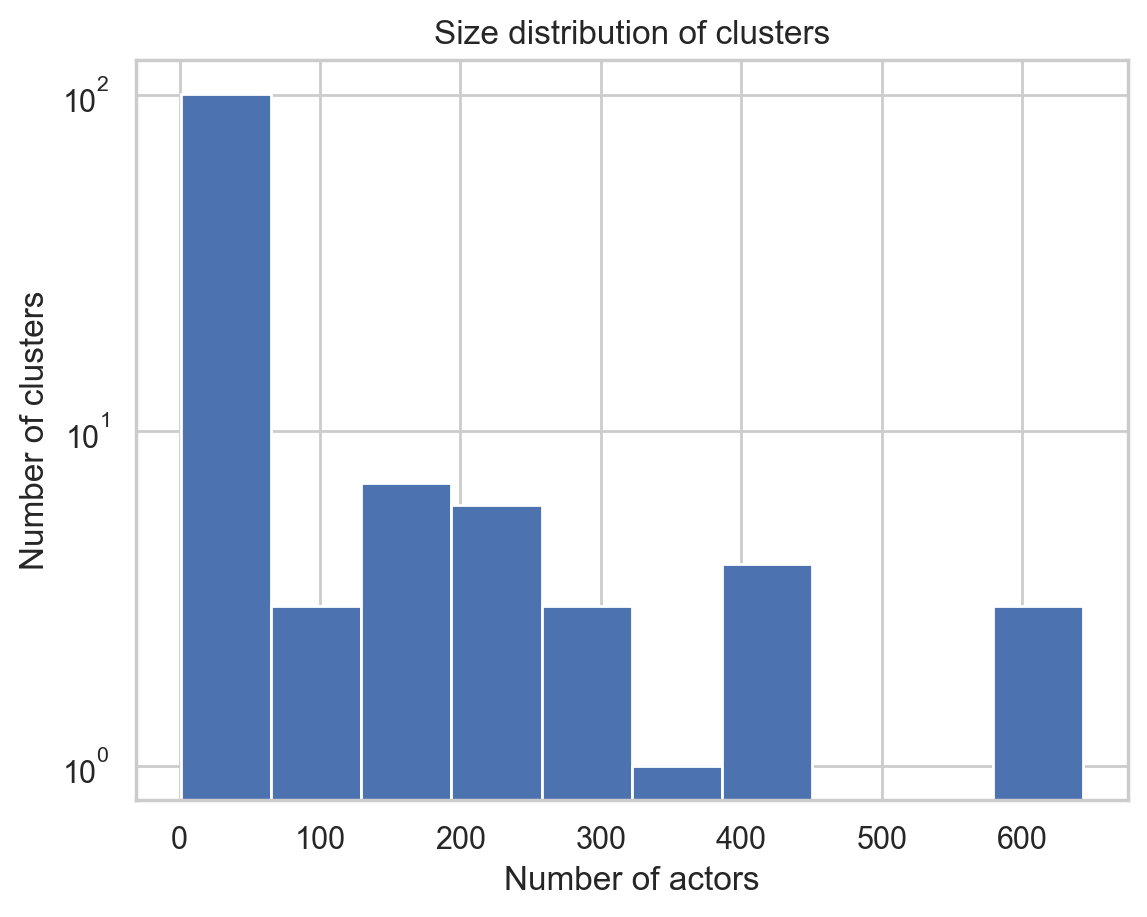

In [45]:
_ = graph_stats.size_distribution(plot=True, log=True, max_value=1000)

Here are some statistics about the distribution of our clusters:

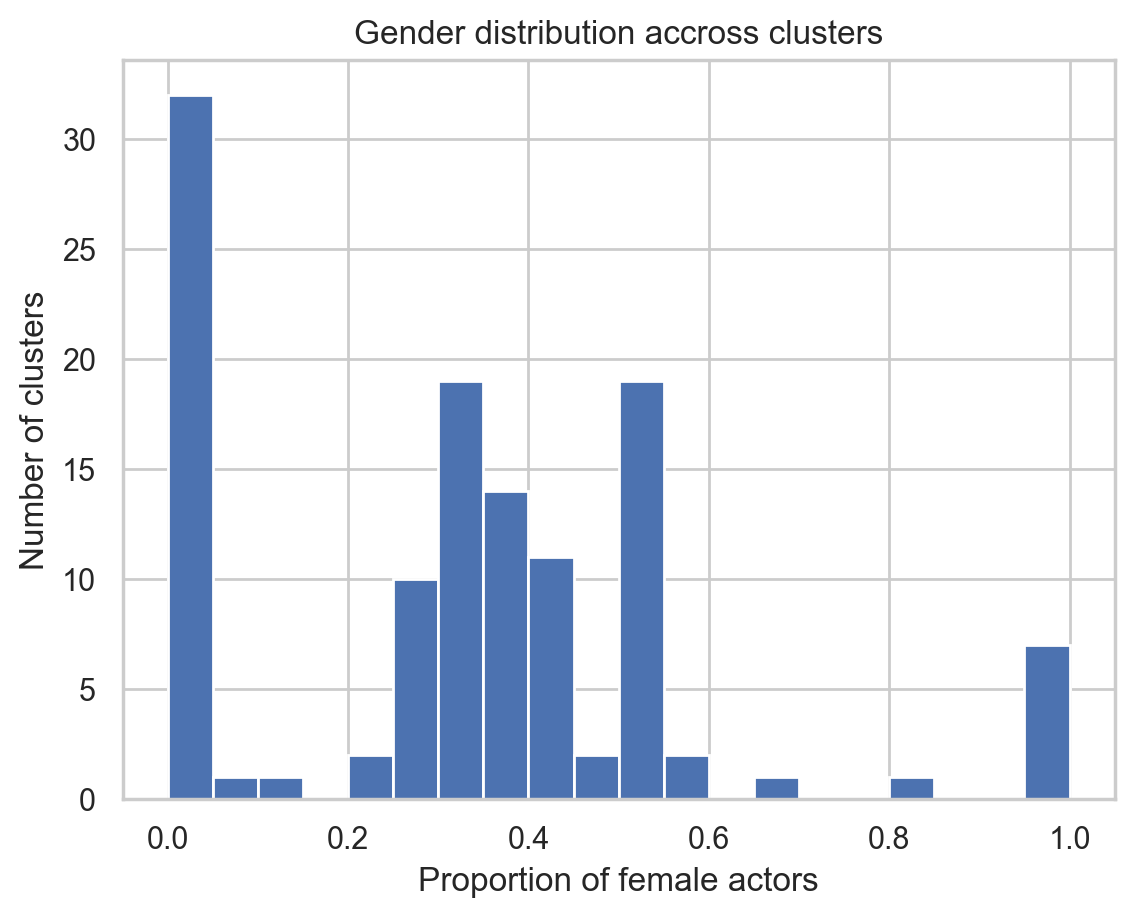

In [46]:
_ = graph_stats.gender_distribution(plot=True)

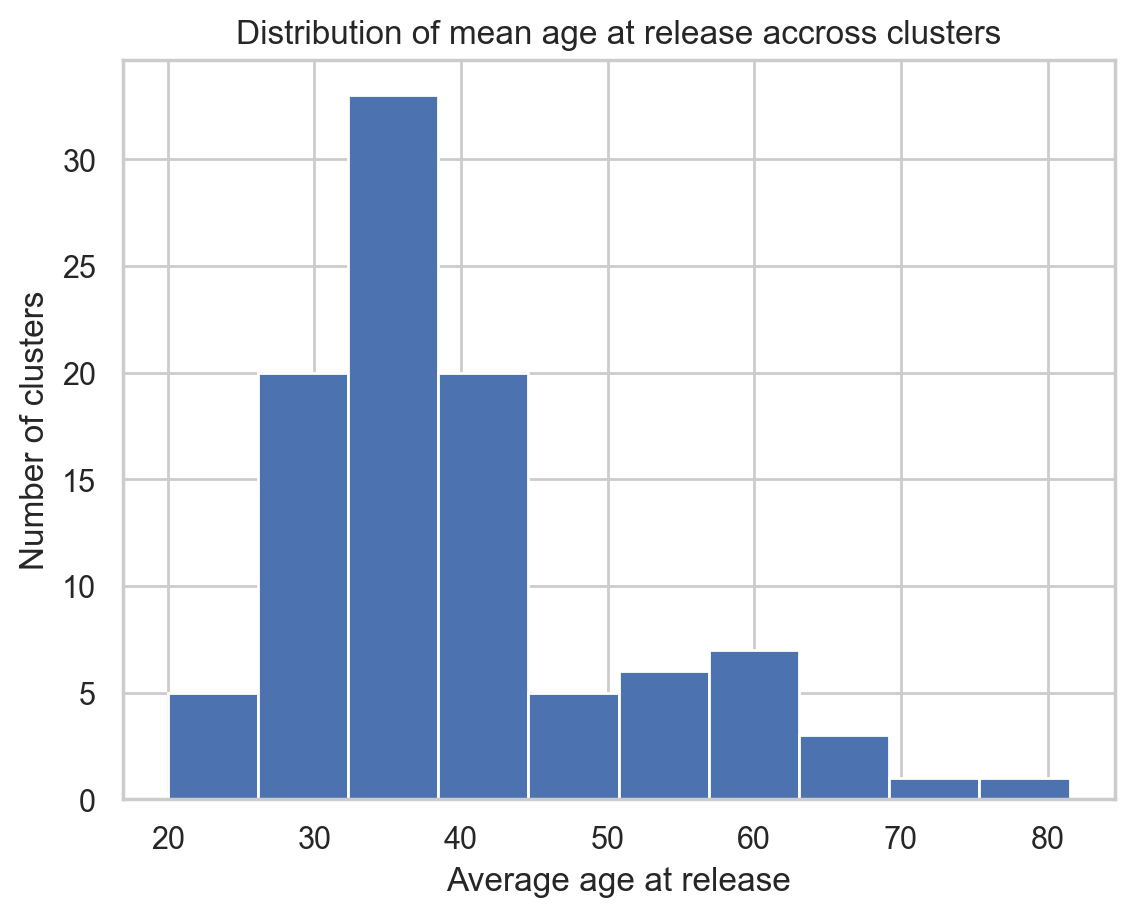

In [47]:
_ = graph_stats.age_distribution(plot=True)

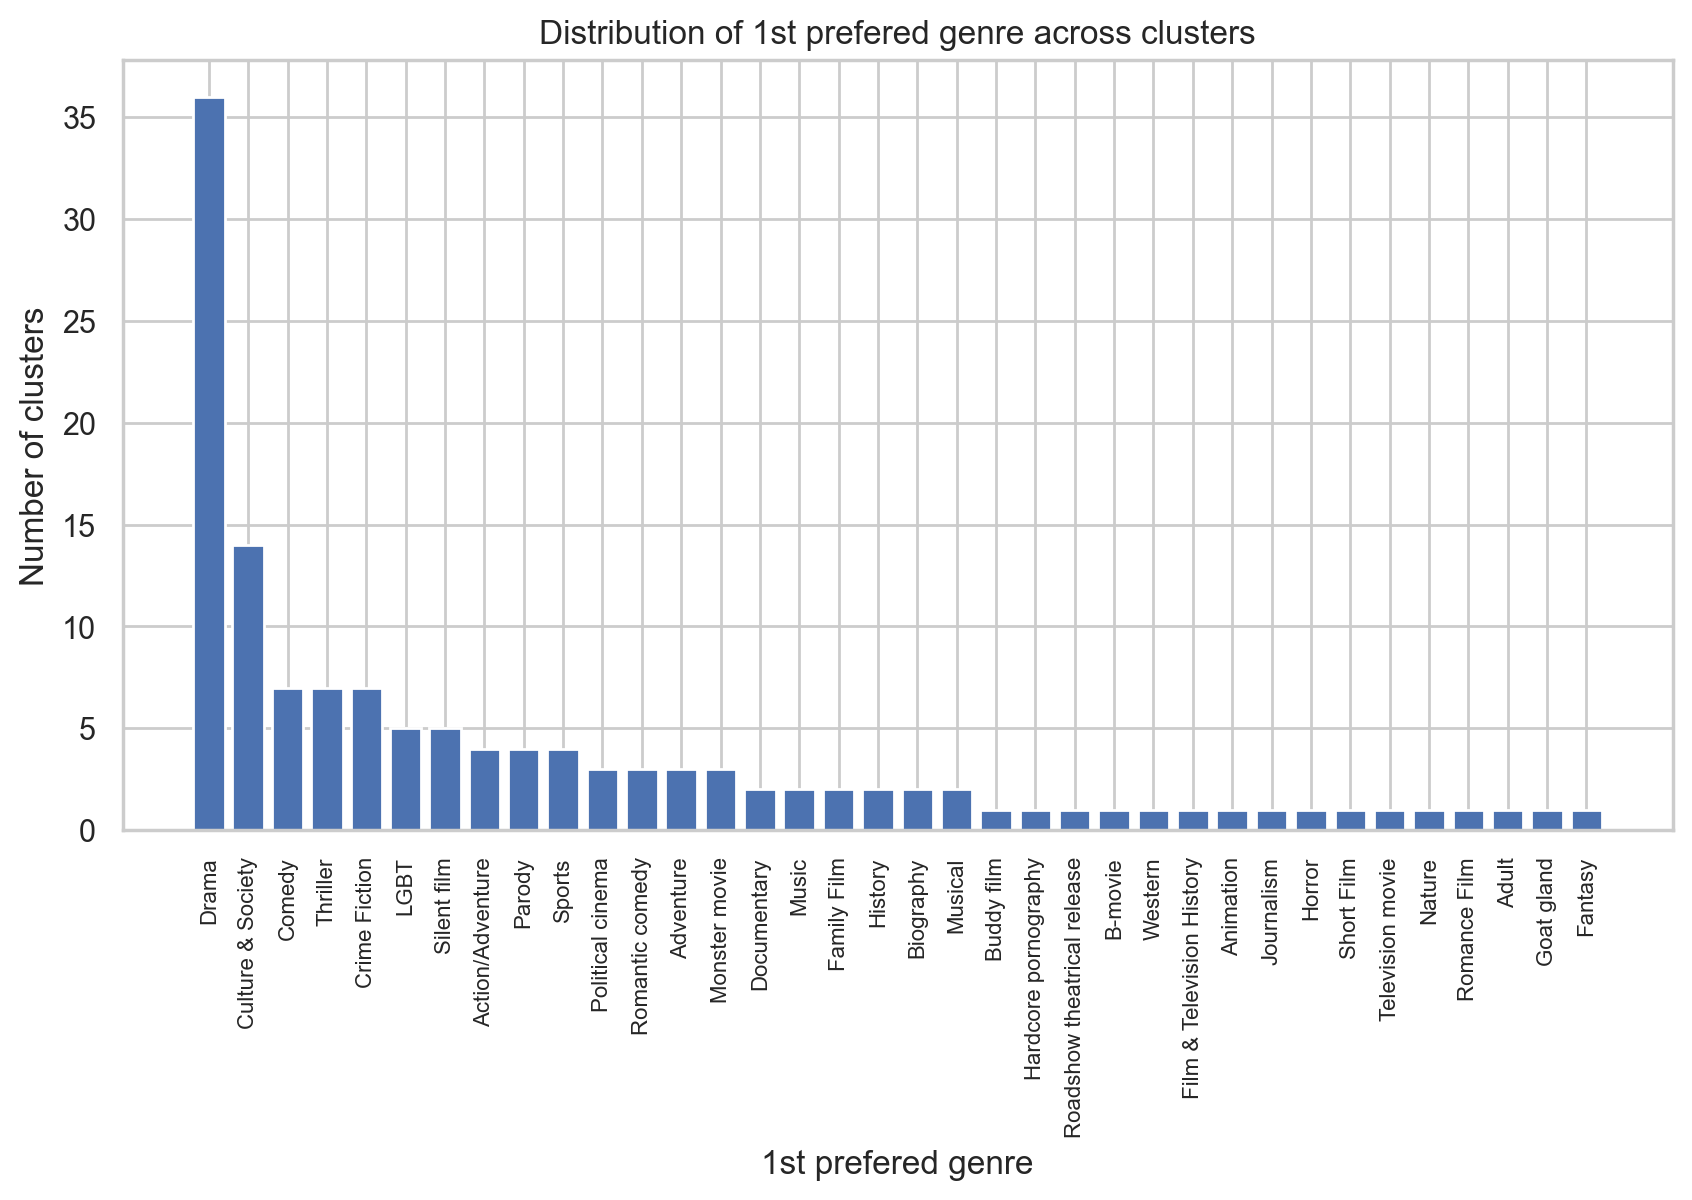

In [48]:
_ = graph_stats.nth_genre_distribution(1, plot=True)

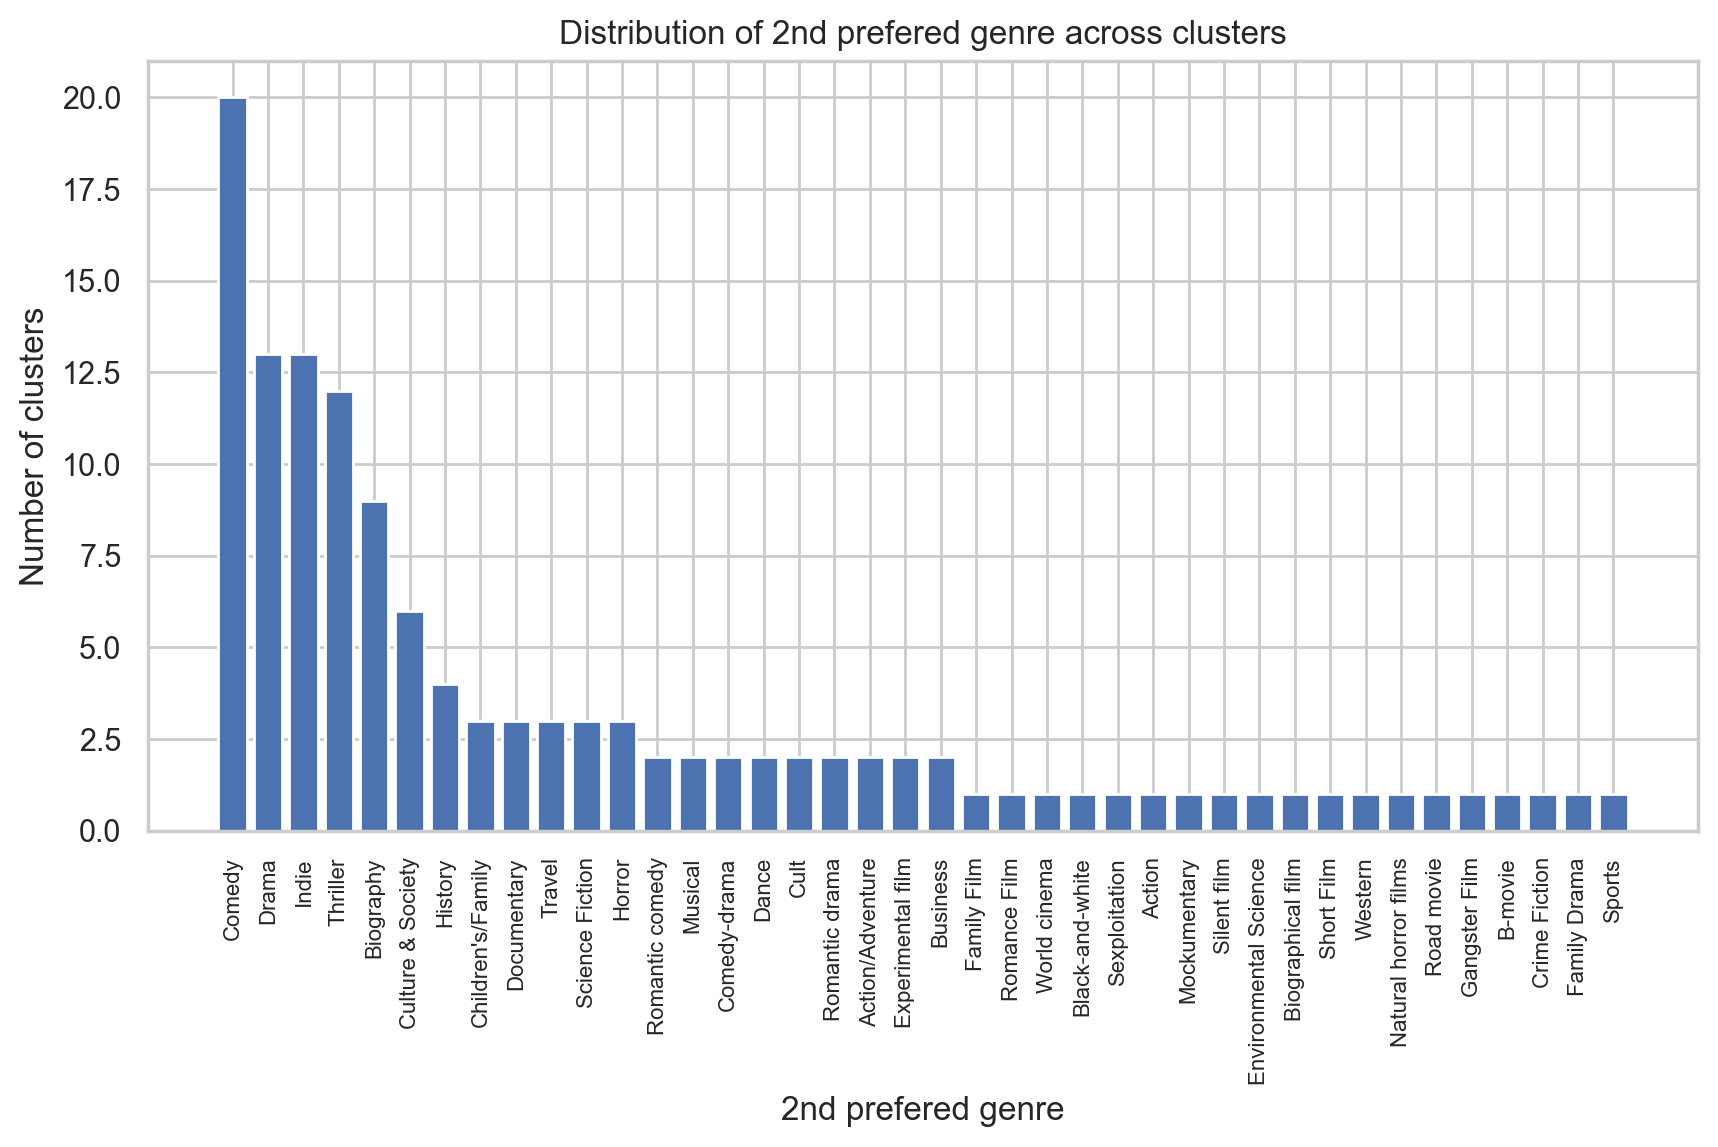

In [49]:
_ = graph_stats.nth_genre_distribution(2, plot=True)

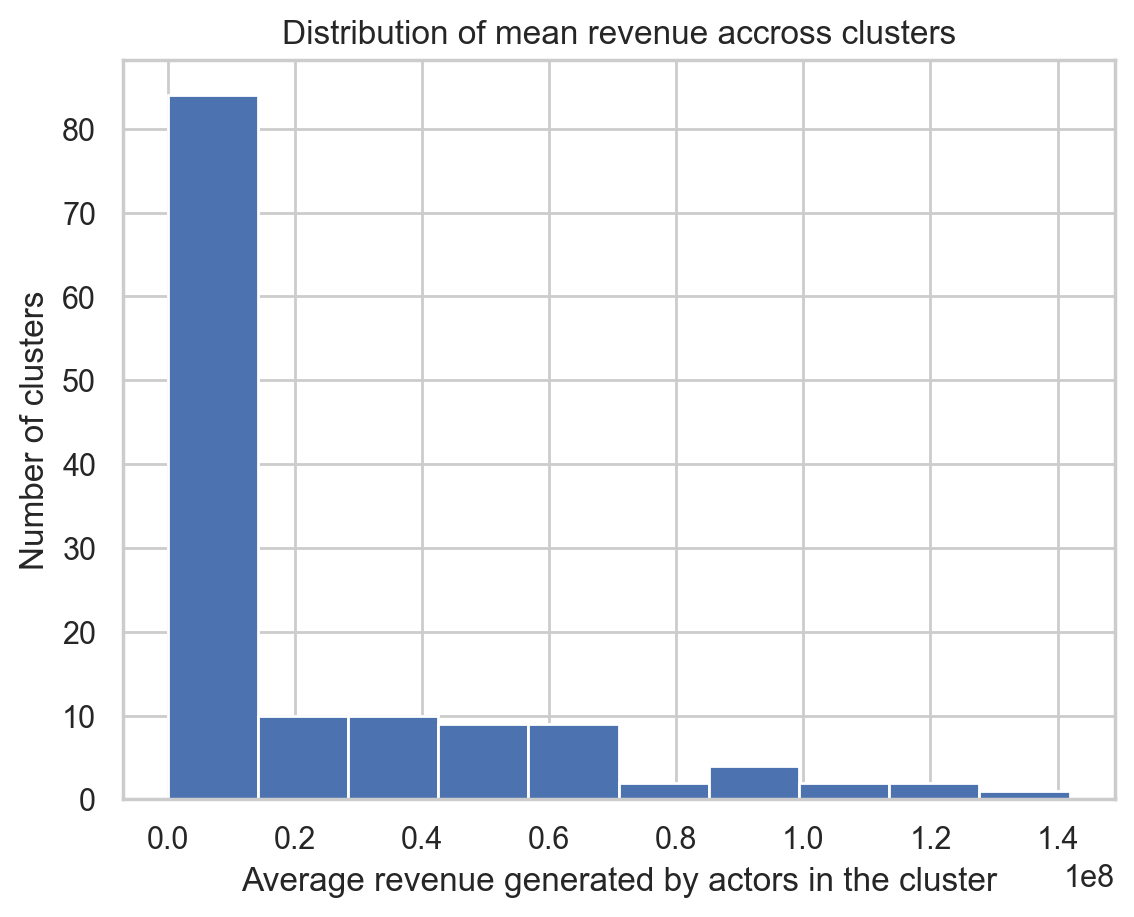

In [50]:
_ = graph_stats.revenue_distribution(plot=True)

# Research Questions

### Question 1

**Awards.** What are the chances that an actor gets an award?

    - Are awarded actors usually together in the same cluster? This means that either a cluster has many actors with awards or none.

In [94]:
from src.awards.helpers import load_awards_and_nominations

actor_awards, actor_nominations, actor_full_awards = load_awards_and_nominations()

Probability of an actor receiving an award: 10.14%
Probability of an actor receiving nominations: 2.90%
Probability of an actor receiving award or nominations: 10.87%


Clusters with high award density (>80%): 19
Clusters with low award density (<20%): 100
Average award density across communities: 22.61%
R2 score for the linreg fit: 0.19107129997076666


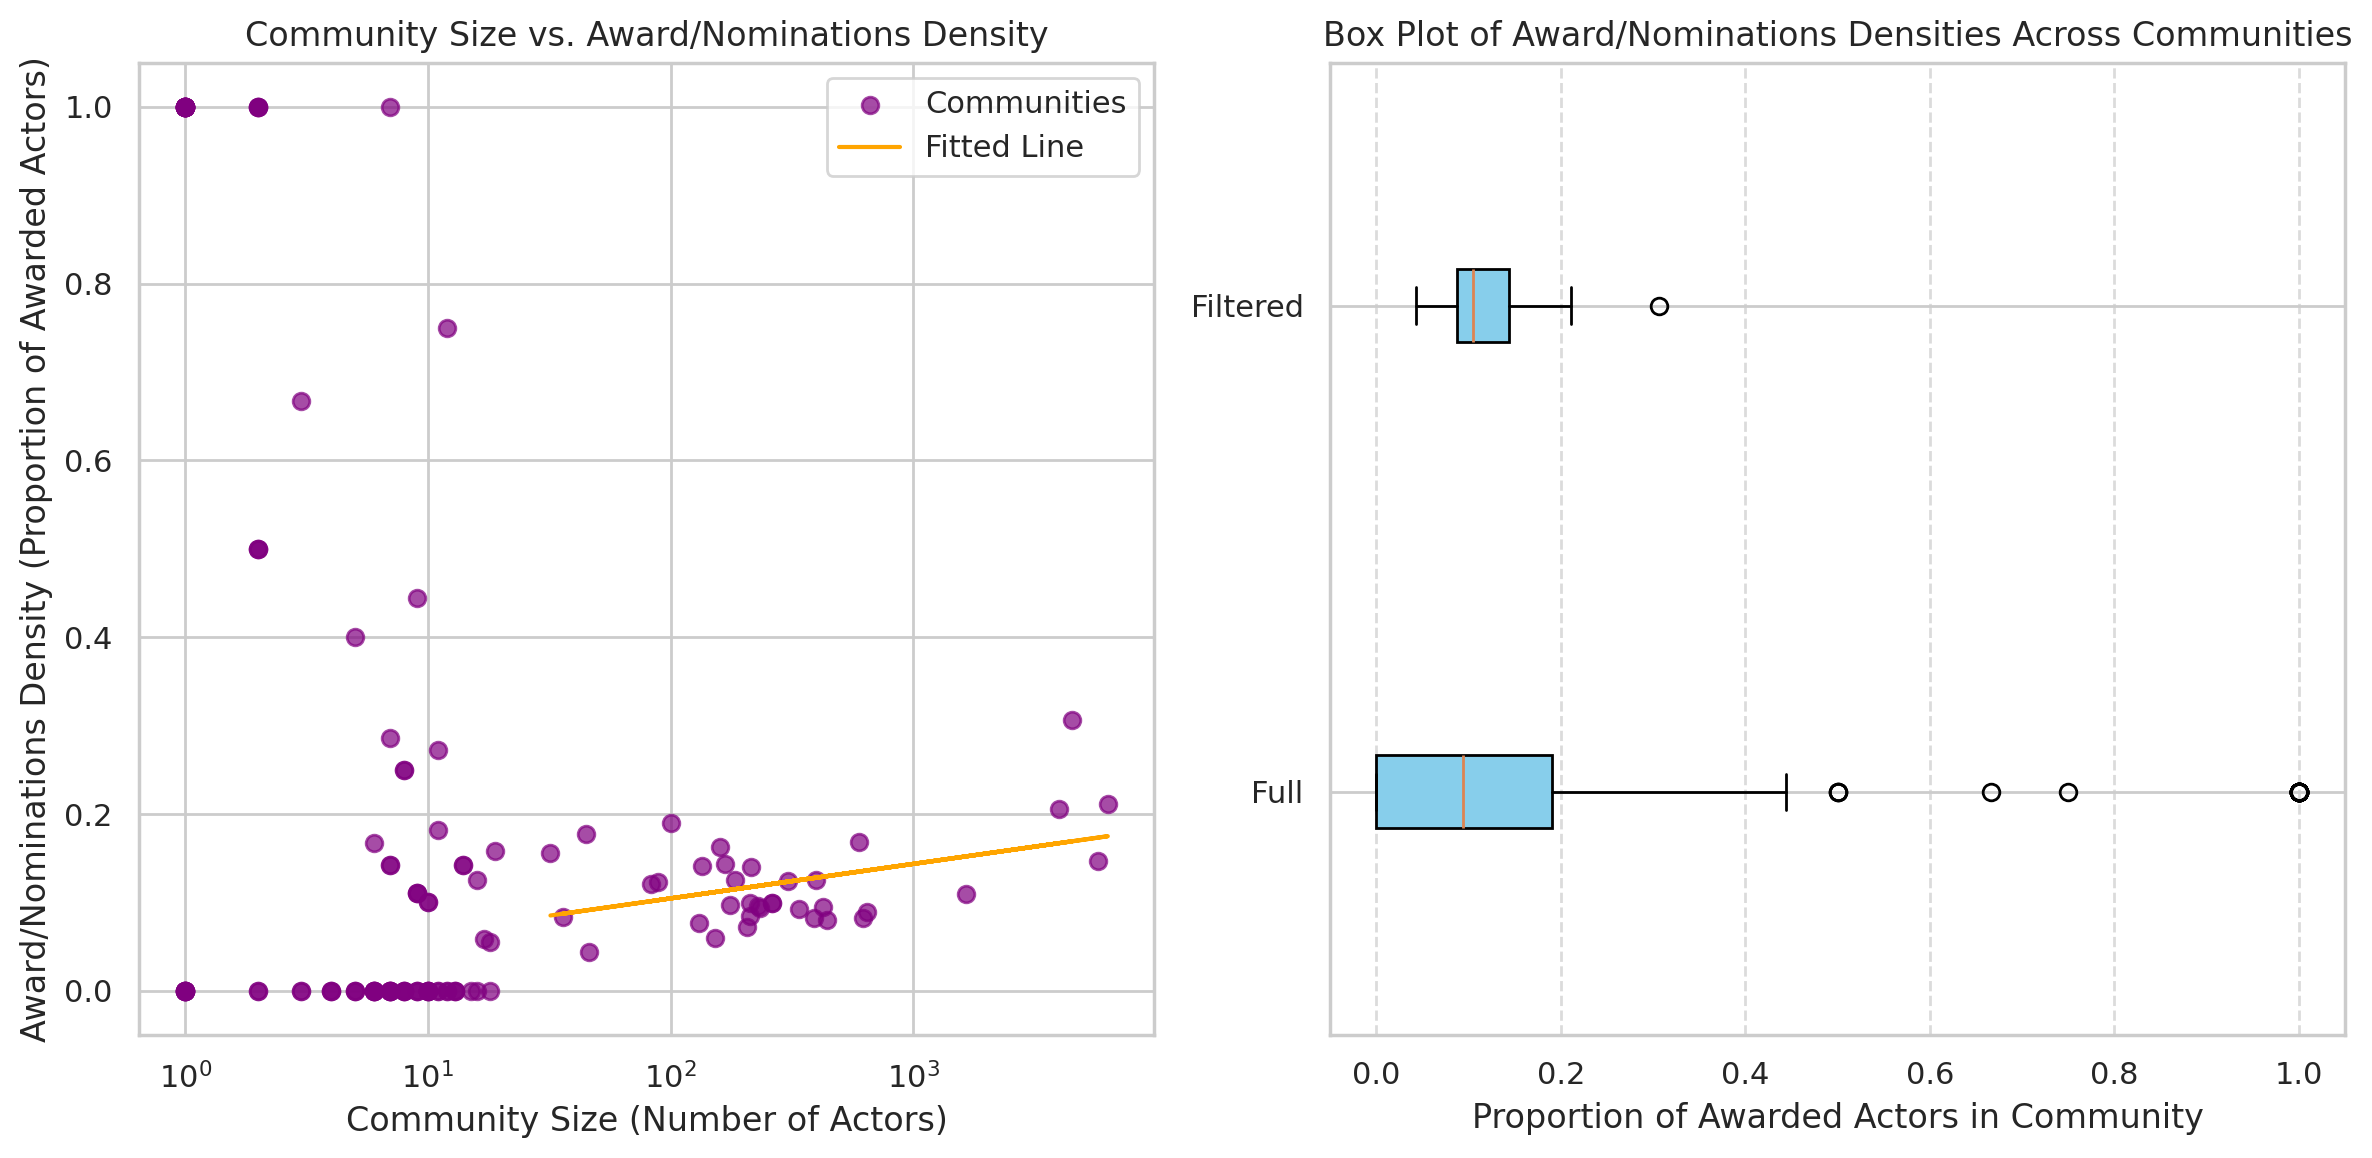

In [96]:
from src.awards.helpers import plot_community_awards_statistics

plot_community_awards_statistics(communities_US, actor_full_awards, boundary=20)

The analysis shows a striking imbalance in the distribution of awarded actors across clusters. Not a single cluster had a high award density (more than 80% of its actors being award winners). On the other hand, the vast majority—129 clusters—had a very low award density, with less than 20% of their actors having received awards.

On average, only about $2.67\%$ of actors in a given community were awarded, indicating that awards are rare and not concentrated within specific clusters. This suggests that awarded actors are widely dispersed among different communities rather than being grouped together. It challenges the idea that certain communities might exclusively consist of highly acclaimed actors. Instead, awards appear to be a less common individual achievement, irrespective of cluster dynamics.

WITH LinReg; we observe that a linear regression model can be fit on the calculated statistics with a reasonable R2: 

### Question 2



**Revenue.** What is the influence of a community on the movie revenue?

    - Cluster comparison analysis. Do certain types of actor clusters (e.g., clusters featuring actors from diverse genres etc.) correlate with higher or lower revenues?

    - Deep Analysis of the top cluster. What are the groups with the most financial success (e.g. highest average revenue / highest total revenue) and what are their characteristics?
    

Let's start with the first sub-question and compare clusters

In [55]:
from src.utils.graphs import Graph

graph_stats = Graph.init_from_list_of_lists(characters=characters,
                                            movies=us_movies,
                                            communities=communities_US)

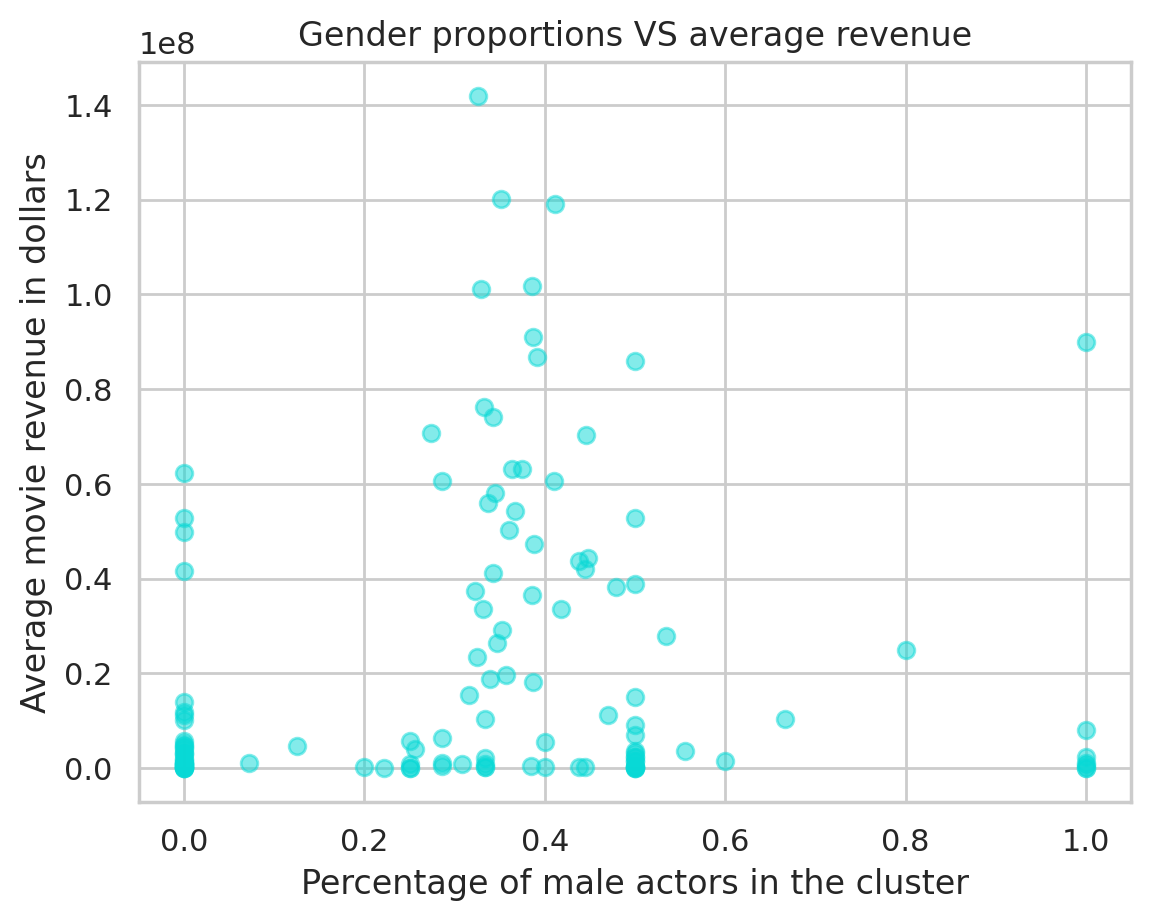

In [56]:
male_proportions, gender_mean_revenues = graph_stats.gender_revenues_graph(plot=True)

In [60]:
from scipy.stats import spearmanr, pearsonr

print("Spearman correlation:", spearmanr(male_proportions, gender_mean_revenues))
print("Pearson correlation:", pearsonr(male_proportions, gender_mean_revenues))

Spearman correlation: SignificanceResult(statistic=0.1295144019305855, pvalue=0.1550835983356419)
Pearson correlation: PearsonRResult(statistic=0.12189085098395387, pvalue=0.18107203932946528)


We do not observe a linear or monotonic correlation between the gender proportions and the average movie revenues. However, looking at the plot, the clusters where actors star in the biggest (revenue-wise) movies seem to have more balanced gender proportions.

Let's look at the impact of age now

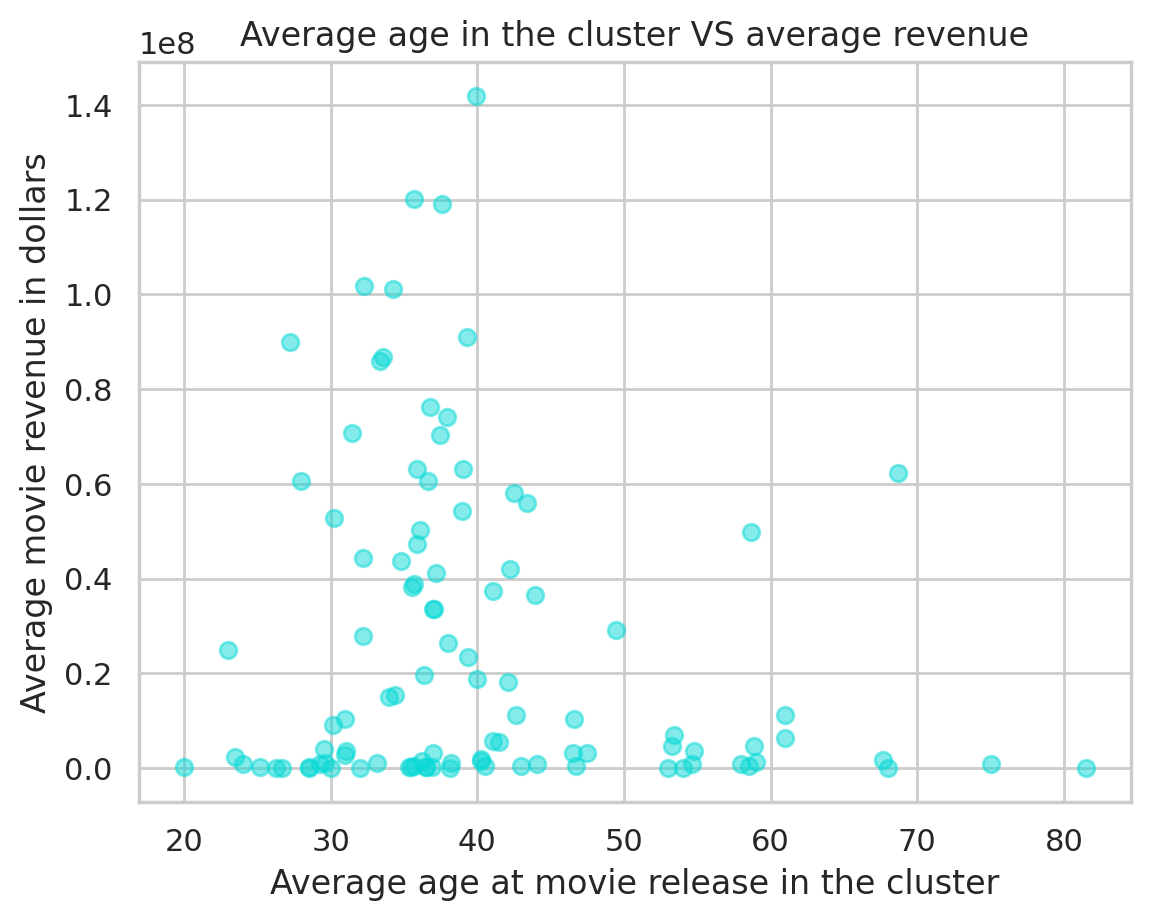

In [61]:
cluster_ages, ages_mean_revenues = graph_stats.age_revenues_graph(plot=True)

In [62]:
print("Spearman correlation:", spearmanr(cluster_ages, ages_mean_revenues))
print("Pearson correlation:", pearsonr(cluster_ages, ages_mean_revenues))

Spearman correlation: SignificanceResult(statistic=-0.0364708006459339, pvalue=0.717288328915892)
Pearson correlation: PearsonRResult(statistic=-0.16727183297005618, pvalue=0.09453649936158359)


Again, there doesn't seem to be a linear correlation between the average age within the cluster and its success. However, looking at the plot it seems that the clusters with an average age between 30 and 40 years have a greater chance to star in a big movie.

In conclusion, it seems that group of actors with balanced genders and an average of around 35 years are the most likely to be successful in the US movie industry.

#### B. Top cluster analysis

Let's complement this general analysis with a deeper look inside one of the most successful group of actors in the industry.

In [64]:
from src.utils.actors import Cluster, ActorStats

# create Cluster class to calculate statistics
clusters = [Cluster(characters, us_movies, community) for community in communities_US]
mean_revenues = graph_stats.revenue_distribution()
median_revenues = graph_stats.median_revenue_distribution()

In [65]:
# get information about the top cluster based on the mean and median revenue
clusters_mean_revenues = sorted(list(zip(clusters, mean_revenues)), key=lambda x: x[1], reverse=True)
top_cluster_mean_revenue = clusters_mean_revenues[0][0]

clusters_median_revenues = sorted(list(zip(clusters, median_revenues)), key=lambda x: x[1], reverse=True)
top_cluster_median_revenue = clusters_median_revenues[0][0]

In [69]:
print(f"""The top cluster in terms of mean revenue ({len(top_cluster_mean_revenue.actor_ids)} \
actors) had an average revenue of {top_cluster_mean_revenue.cluster_mean_revenue():.0f}$ \
and a median revenue of {top_cluster_mean_revenue.cluster_median_revenue():.0f}$.""")
print(f"""The top cluster in terms of median revenue ({len(top_cluster_median_revenue.actor_ids)} \
actors) had a median revenue of {top_cluster_median_revenue.cluster_median_revenue():.0f}$ \
and a mean revenue of {top_cluster_median_revenue.cluster_mean_revenue():.0f}$.""")

The top cluster in terms of mean revenue (3979 actors) had an average revenue of 141886319$ and a median revenue of 51316673$.
The top cluster in terms of median revenue (212 actors) had a median revenue of 99274467$ and a mean revenue of 101186712$.


We will now take a closer look at the top cluster in terms of median revenue, which achieved a median revenue of around 99 million dollars. Median revenue is a sign of consistency in producing successfull movies, as opposed to a high average which can be caused by a single hit. In comparison, the top cluster in terms of mean revenue only has around 51 millions dollars of median revenue. Furthermore, the top cluster in terms of median revenue contains a fair amount of actors (212), which helps to make a meaningful analysis.

In [70]:
cluster_actor_names = top_cluster_median_revenue.cluster_actors()
# print(f"{len(cluster_actor_names)} actors: {cluster_actor_names}")

In [71]:
whole_us_industry = Cluster(characters, us_movies, [a for c in communities_US for a in c])

This group of actors has about the same gender proportions as the whole industry:

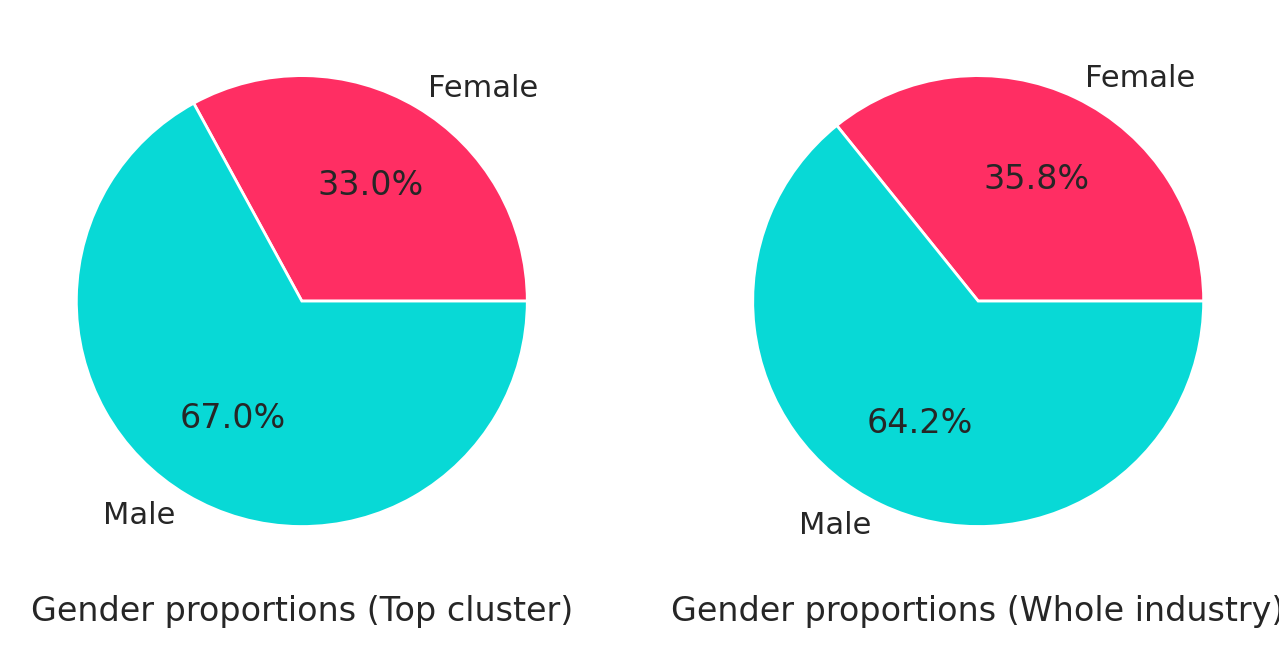

In [72]:
titles = ["Gender proportions (Top cluster)", "Gender proportions (Whole industry)"]
top_cluster_median_revenue.compare_genders_with(whole_us_industry, titles)

In terms of age, this cluster is slightly younger than the rest of the industry:

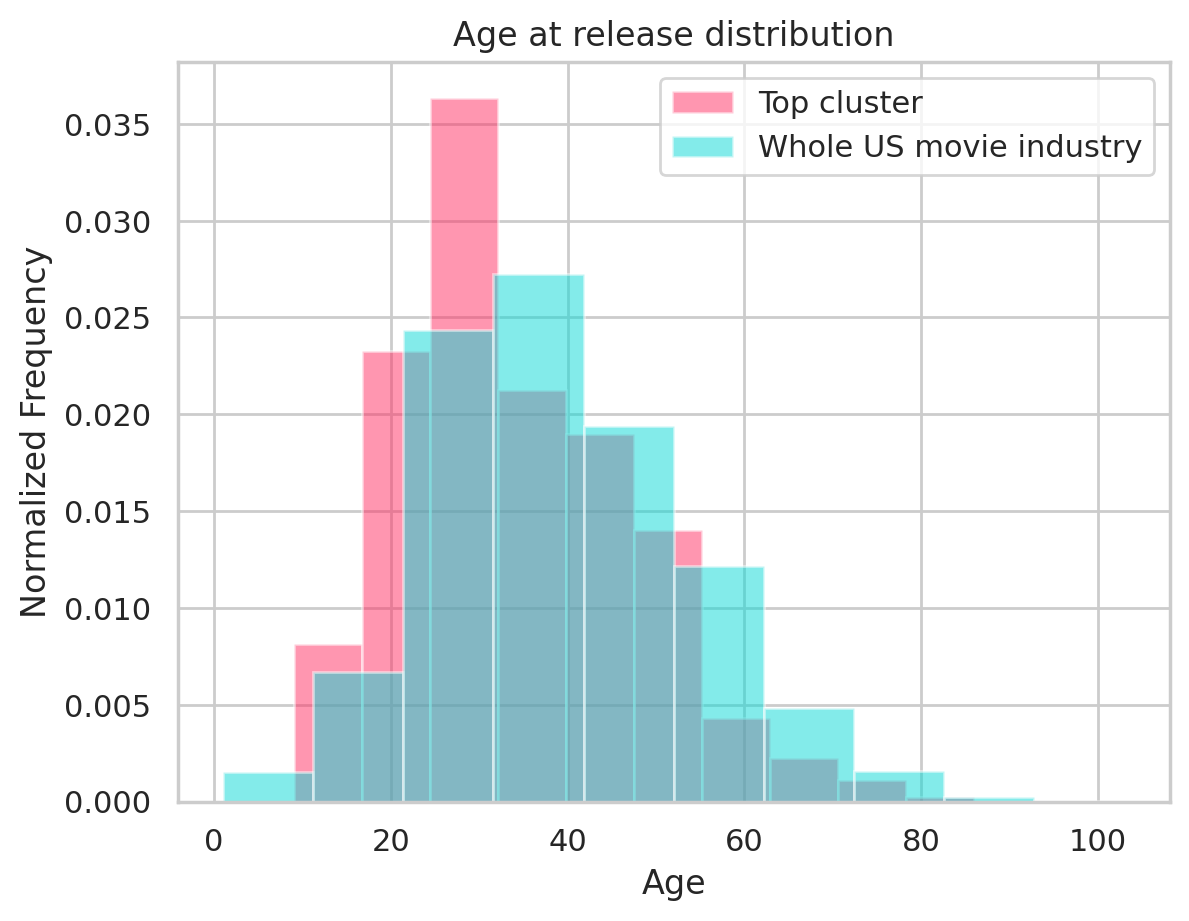

In [73]:
labels = ["Top cluster", "Whole US movie industry"]
top_cluster_median_revenue.compare_ages_with(whole_us_industry, labels)

More than 12 billion dollars were generated by them:

In [74]:
print(f"Total money generated by movies in this cluster: {top_cluster_median_revenue.cluster_total_revenue()}$")

Total money generated by movies in this cluster: 12592219567.0$


By playing in these movies:

In [75]:
top_cluster_movies = top_cluster_median_revenue.cluster_movies()
# print(f"{len(top_cluster_movies)} movies: {list(top_cluster_movies['MovieName'])}")

The most profitable movies in that list are:

In [76]:
top_cluster_movies.sort_values(by="Revenue", ascending=False)[["MovieName", "Revenue"]].head(10)

MovieName      Revenue
8821   The Lord of the Rings: The Two Towers  926047111.0
35156                    The Matrix Reloaded  742128461.0
78373                       The Hunger Games  686533290.0
73546                              King Kong  550500000.0
18469                  X-Men: The Last Stand  459359555.0
15862                           Pearl Harbor  449220945.0
37723                 The Matrix Revolutions  427343298.0
65985                           Tron: Legacy  400062763.0
78389                          Batman Begins  372710015.0
16587                             Shark Tale  367275019.0

What about genres distribution?

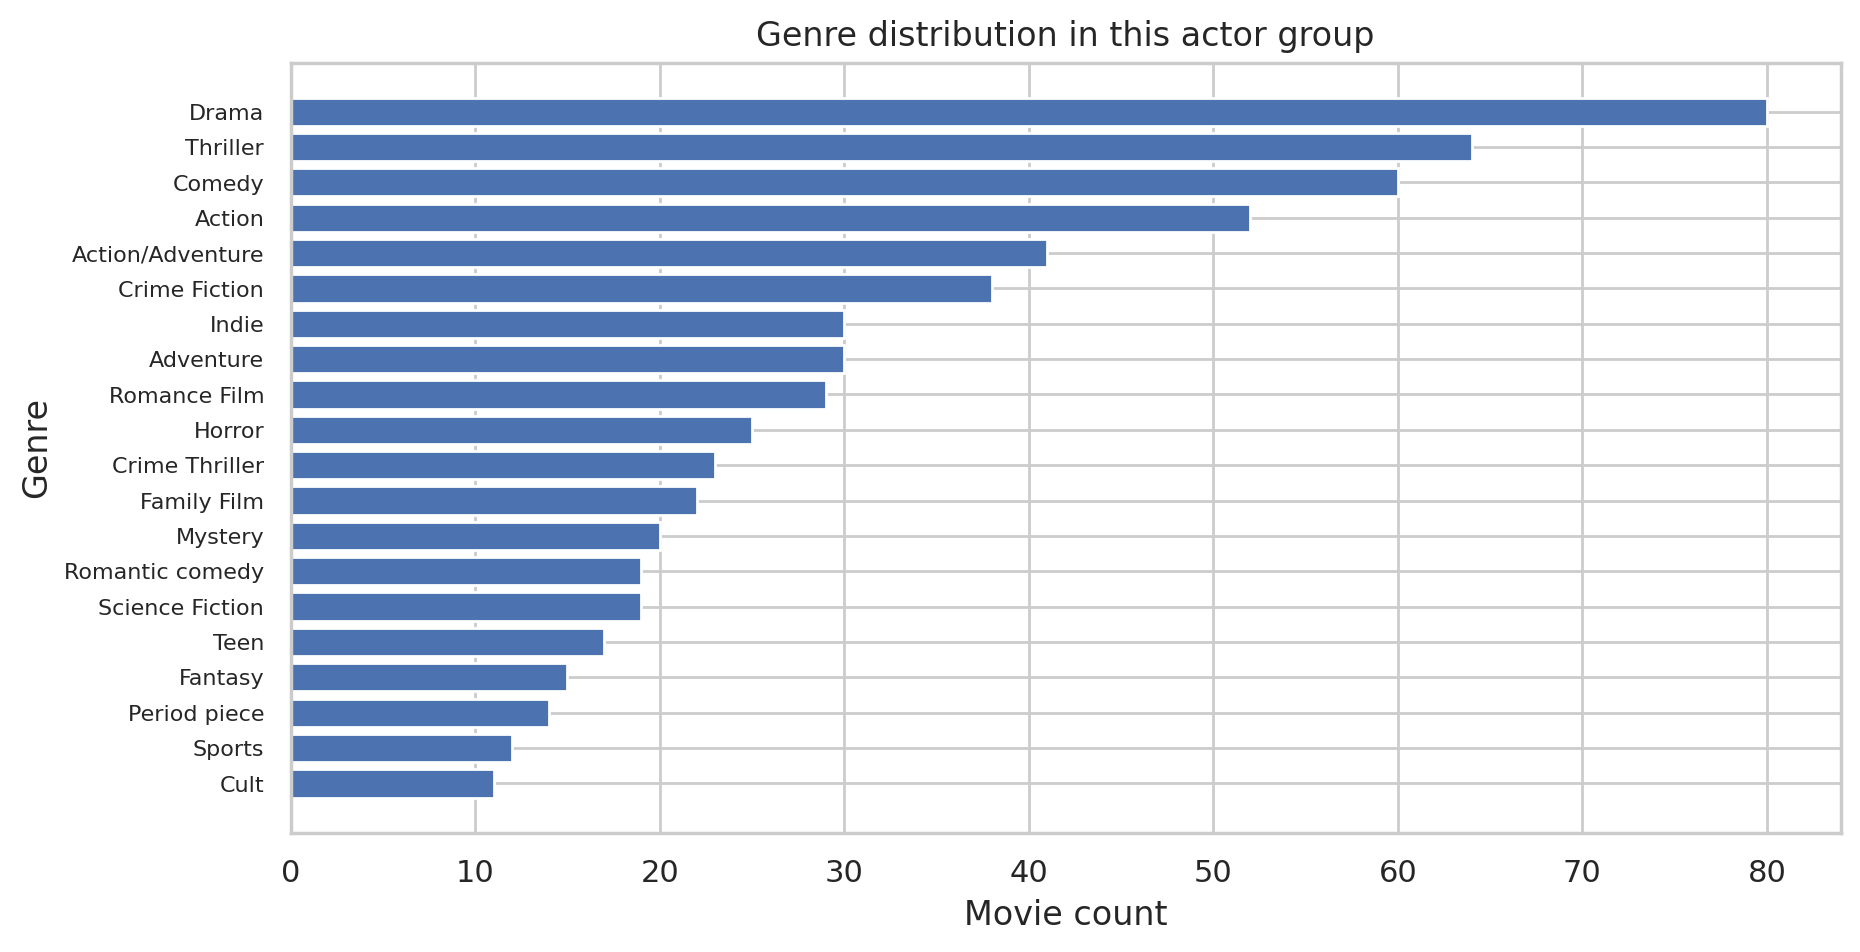

In [78]:
_ = top_cluster_median_revenue.cluster_genres(plot=True)

"Drama", "Thriller", "Comedy", "Action" and "Adventure" are the prefered genres in this actor group.

Let's now have a look at the cluster structure:

In [79]:
actor_stats = ActorStats(characters, us_movies)

In [80]:
top_cluster_graph = G_US.subgraph(top_cluster_median_revenue.actor_ids)
nx.set_node_attributes(top_cluster_graph, 
                       dict([(actor_id, actor_stats.actor_name(actor_id)) for actor_id in top_cluster_graph.nodes()]),
                       'Name')
print(top_cluster_graph)

Graph with 212 nodes and 2118 edges


Who are the most important actors in this cluster? We will use different centrality measures to find out.

To get rid of minor actors, we start by creating a smaller graph where we only keep actors who played in at least 2 movies.

In [81]:
top_cluster_movie_counts = list(zip(top_cluster_median_revenue.actor_ids, 
                               list(map(lambda actor_id: actor_stats.actor_movies(actor_id).shape[0],
                                        top_cluster_median_revenue.actor_ids))))

In [82]:
small_actors = [actor_id for actor_id, movie_count in top_cluster_movie_counts if movie_count < 2]
smaller_graph = top_cluster_graph.copy()
smaller_graph.remove_nodes_from(small_actors)
print(smaller_graph)

Graph with 58 nodes and 233 edges


Katz centrality

In [83]:
from src.utils.networkx_helpers import katz_centrality
katz = katz_centrality(smaller_graph)

Kate S. Butler has katz-centrality: 0.250
Craig Hall has katz-centrality: 0.246
Joel Tobeck has katz-centrality: 0.246
Jared Turner has katz-centrality: 0.241
Elizabeth Hawthorne has katz-centrality: 0.241


Closeness centrality

In [84]:
from src.utils.networkx_helpers import closeness_centrality
closeness = closeness_centrality(smaller_graph)

Josh Hutcherson has closeness-centrality: 0.432
Ed Gale has closeness-centrality: 0.419
Kate S. Butler has closeness-centrality: 0.416
Josh Hartnett has closeness-centrality: 0.380
Eddie Deezen has closeness-centrality: 0.377


Betweenness centrality

In [85]:
from src.utils.networkx_helpers import betweenness_centrality
bet_centrality = betweenness_centrality(smaller_graph)

Josh Hutcherson has betweenness-centrality: 0.359
Ed Gale has betweenness-centrality: 0.296
Kate S. Butler has betweenness-centrality: 0.199
Stephen E. Miller has betweenness-centrality: 0.193
Eddie Deezen has betweenness-centrality: 0.192


To represent the importance of an actor in the community, we'll use the average of the previous centrality measures:

In [86]:
from src.utils.networkx_helpers import importance
importance(smaller_graph, bet_centrality, closeness, katz)

Josh Hutcherson has centrality: 1.000
Kate S. Butler has centrality: 0.975
Ed Gale has centrality: 0.887
Josh Hartnett has centrality: 0.885
Eddie Deezen has centrality: 0.727


We can now visualize the community, where actor names have a font size proportional to their importance in the community. 

In [121]:
from src.utils.networkx_helpers import visualize_graph
visualize_graph(smaller_graph, "data/results/question2/top_cluster_graph.png", k=0.8, alpha=0.6)

### Question 3

In [110]:
from src.awards.helpers import load_awards_and_nominations

actor_awards, actor_nominations, actor_full_awards = load_awards_and_nominations()
us_actor_full_awards = actor_full_awards[actor_full_awards.FreebaseActorId.isin(us_characters_movies.FreebaseActorId.unique())]

Probability of an actor receiving an award: 10.14%
Probability of an actor receiving nominations: 2.90%
Probability of an actor receiving award or nominations: 10.87%


R2 score for the linreg fit: 0.8250126170053902


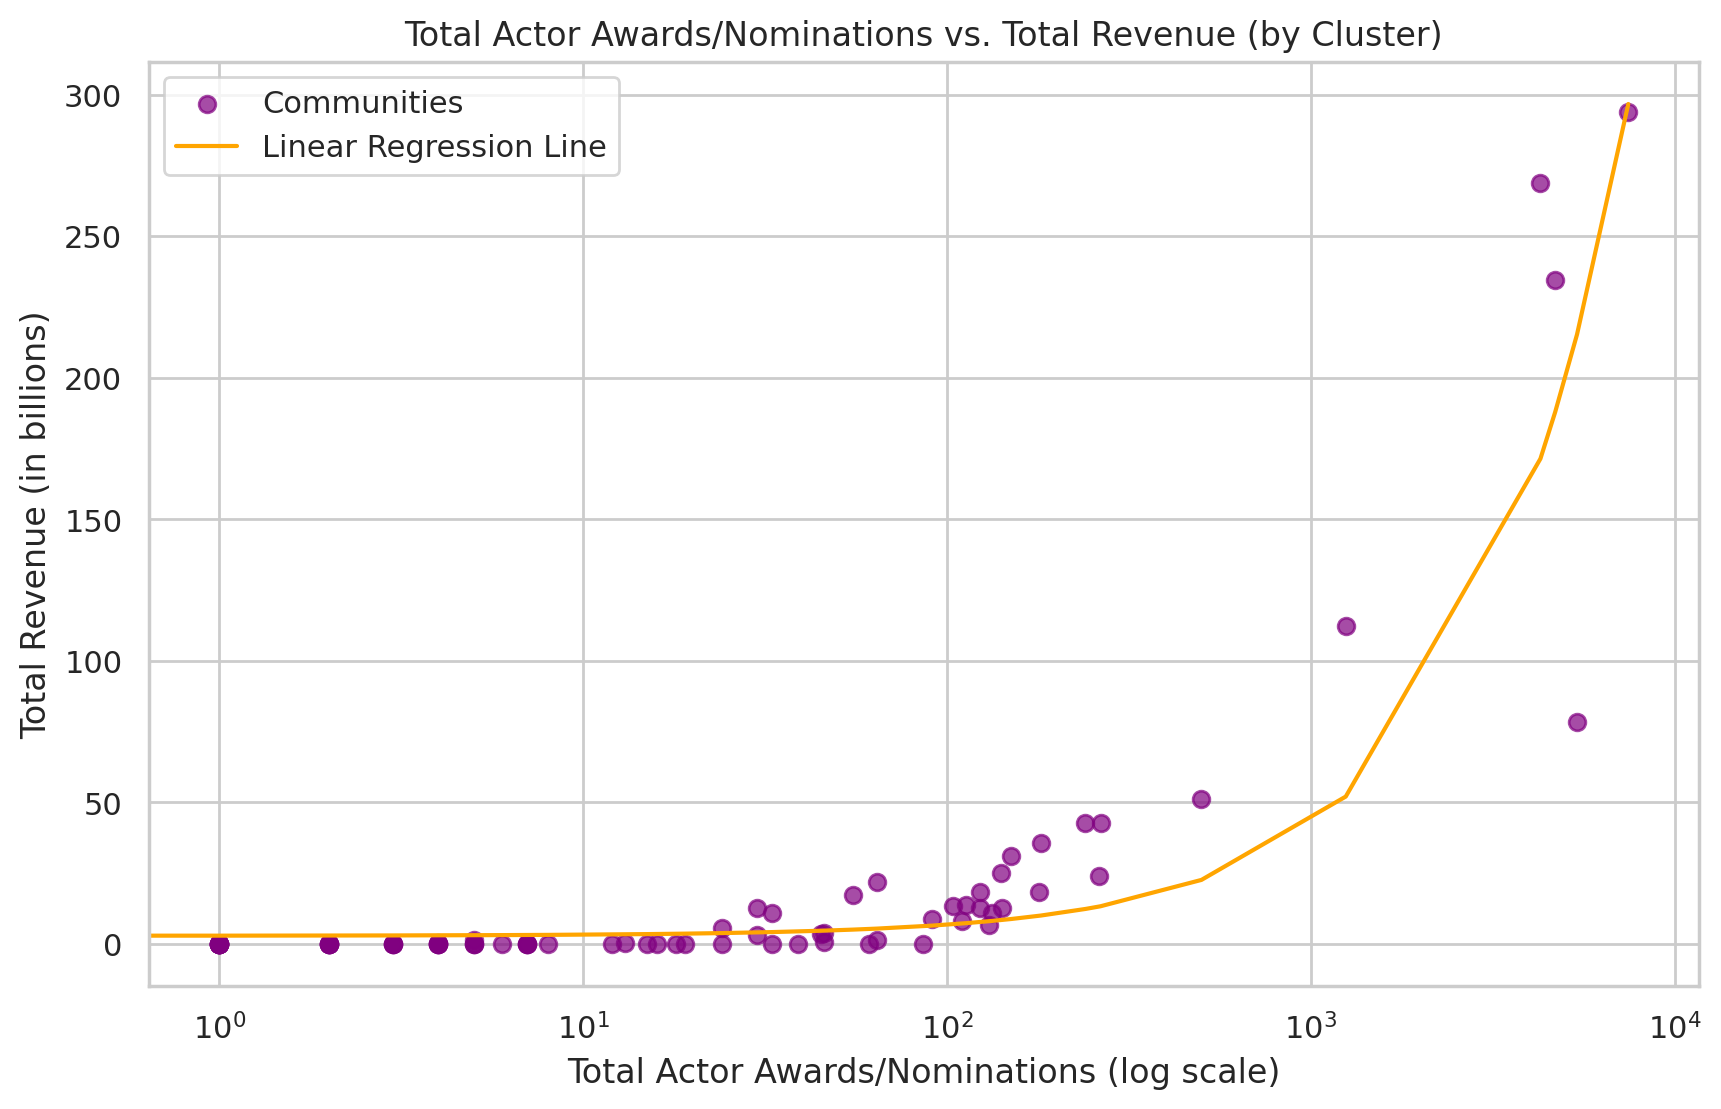

Spearman correlation: SignificanceResult(statistic=0.6963705815335739, pvalue=1.3285027298324224e-20)
Pearson correlation: PearsonRResult(statistic=0.9083020516355725, pvalue=1.997545295283512e-51)


In [120]:
from src.awards.helpers import plot_actors_award_nominations_revenue
plot_actors_award_nominations_revenue(communities_US, us_movies, us_characters_movies, us_actor_full_awards)

When a new movie is promoted, trailers often highlight achievements of the cast: "This film features award-winning actors!" The idea behind this marketing approach is clear—audiences are drawn to movies starring celebrated performers. The assumption is that if an actor has won prestigious awards or received multiple nominations, their presence in a film will make it more appealing to viewers, ultimately leading to greater box office success.

But is this really the case? Does hiring actors with awards and nominations translate into higher revenue for movies? This question is at the heart of the analysis, where we explore whether communities of actors with the most awards and nominations are also associated with the highest earning films.

Correlation Analysis
Correlation between total actor awards and total revenue: 0.92
Correlation between total actor nominations and total revenue: 0.93

These findings indicate a very strong positive relationship between the recognition (awards and nominations) of actors in a community and the revenue generated by the movies they participate in. Communities with more awards and nominations tend to be associated with higher revenues.

Community Outliers
The largest communities in the actor graph, comprising thousands of actors, exhibit significantly higher total revenues, awards, and nominations.

### Question 4

#### Testing whether the communities are overall stable

In [98]:
from src.utils.helpers import read_communities

ITERATIONS = 100

def count_communities_list_occurences(communities_list, actor_l, actor_r):
    sm = 0
    for communities in communities_list:
        has_both = False
        for community in communities:
            if actor_l in community and actor_r in community:
                has_both = True
                break
        sm += 1 if has_both else 0
    return sm


G_cooccurrences = nx.Graph()
communities_list = []
communities_list_probs = []
for communities_seed in range(1, 6):
    communities_US = read_communities(G_US, f"data/processed/new_communities_US_{communities_seed}.json")
    communities_list.append(communities_US)
    probs = []
    for community in communities_US:
        probs.append((len(community) * (len(community) - 1)) // 2)
    probs = np.array(probs, dtype=float)
    probs /= probs.sum()
    communities_list_probs.append(probs)

cooccs = []
for i, community in enumerate(communities_list):
    if len(community) == 1:
        continue
    community_to_sample = np.random.choice(len(communities_list_probs[i]), size=ITERATIONS, p=communities_list_probs[i])
    for j in range(ITERATIONS):
        actor_l, actor_r = np.random.choice(communities_list[i][community_to_sample[j]], size=2, replace=False)
        coocc = count_communities_list_occurences(communities_list, actor_l, actor_r)
        cooccs.append(coocc)
cooccs = np.array(cooccs)
print(f'The probability of a pair of actors being in the same cluster again is about {cooccs.mean() / 5}')

The probability of a pair of actors being in the same cluster again is about 0.7272000000000001


#### Testing whether the biggest communities are stable

The result of the Louvian algorithm depends on the seed it is initialized with.
We will try to determine whether generated communities depend on the seed we use. To do that, we will consider multiple runs with $5$ different seeds.

For each ordered pair of runs we will match the communities of the first run to the communities of the second run. The matching procedure works like this:

Go over all communities in the run in the decreasing size order
1. For each community in the loop determine the community of the second run with the biggest intersection that wasn't yet picked
2. Mark the found community from the second run as picked

Using the information about matched communities, we will build a _matching graph_, where edges will be of the form $(i;j)$, where $i$ is the number of the run and $j$ is the community, we will draw a directed edge between $(i_{1};j_{1})$ and $(i_{2};j_{2})$ if the fraction of actors present in $(i_{1};j_{1})$ that is also present in $(i_{2};j_{2})$ is at least $0.8$, on the edge we will write this number.

If all the seeds produced the same result, we would get a set of complete graphs, of the form $\{(0;i), (1;i), \ldots, (5;i) \}$. But because different seeds produce different results, the subgraphs might be not complete. To determine stable communities, we will be looking for connected components that are "close to completeness": they have many edges between vertices.

In [85]:
from src.utils.helpers import read_communities

communities_US_list = []
communities_US_set_list = []
actor_id_to_community_list = []

for i in range(1, 6):
    communities_US = read_communities(G_US, f"data/processed/new_communities_US_{i}.json")
    communities_US = sorted(communities_US, key=lambda x: len(x), reverse=True)

    actor_id_to_community = dict()
    for i, community in enumerate(communities_US):
        for actor_id in community:
            actor_id_to_community[actor_id] = i

    actor_id_to_community_list.append(actor_id_to_community)
    communities_set_US = list(map(set, communities_US))
    communities_US_list.append(communities_US)
    communities_US_set_list.append(communities_set_US)

def map_communities(idx_i, idx_j):
    communities_i = communities_US_list[idx_i]
    communities_used_j = set()
    map_community = [-1 for _ in range(len(communities_i))]
    matching_percent = [0 for _ in range(len(communities_i))]
    for i, community in enumerate(communities_i):
        count_community = dict()
        for actor_id in community:
            other_community = actor_id_to_community_list[idx_j][actor_id]
            if other_community not in communities_used_j:
                count_community[other_community] = count_community.get(other_community, 0) + 1
        map_community[i] = max(count_community.items(), key=lambda x: x[1])[0] if len(count_community) > 0 else -1
        if map_community[i] != -1:
            matching_percent[i] = count_community[map_community[i]] / len(community)
            communities_used_j.add(map_community[i])
    return list(zip(map_community, matching_percent))


G = nx.DiGraph()
for i in range(5):
    for j in range(5):
         if i != j:
            mapping = map_communities(i, j)
            TAKE_CONST = 10
            for idx_from, stats_pair in enumerate(mapping[:TAKE_CONST]):
                from_v = f"{i};{idx_from}"
                to_v = f"{j};{stats_pair[0]}"
                if stats_pair[1] > 0.8: # int(idx_from) < TAKE_CONST and int(stats_pair[0]) < TAKE_CONST
                    G.add_edge(from_v, to_v, weight=round(stats_pair[1], 2))

Matching graph of the first $10$ communities

In [86]:
def draw_G(G, k=0.5, iterations=50, seed=1):
    pos=nx.spring_layout(G, k=k, iterations=iterations, seed=seed)
    nx.draw(G,pos, edge_cmap=plt.cm.Reds, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)
    plt.show()

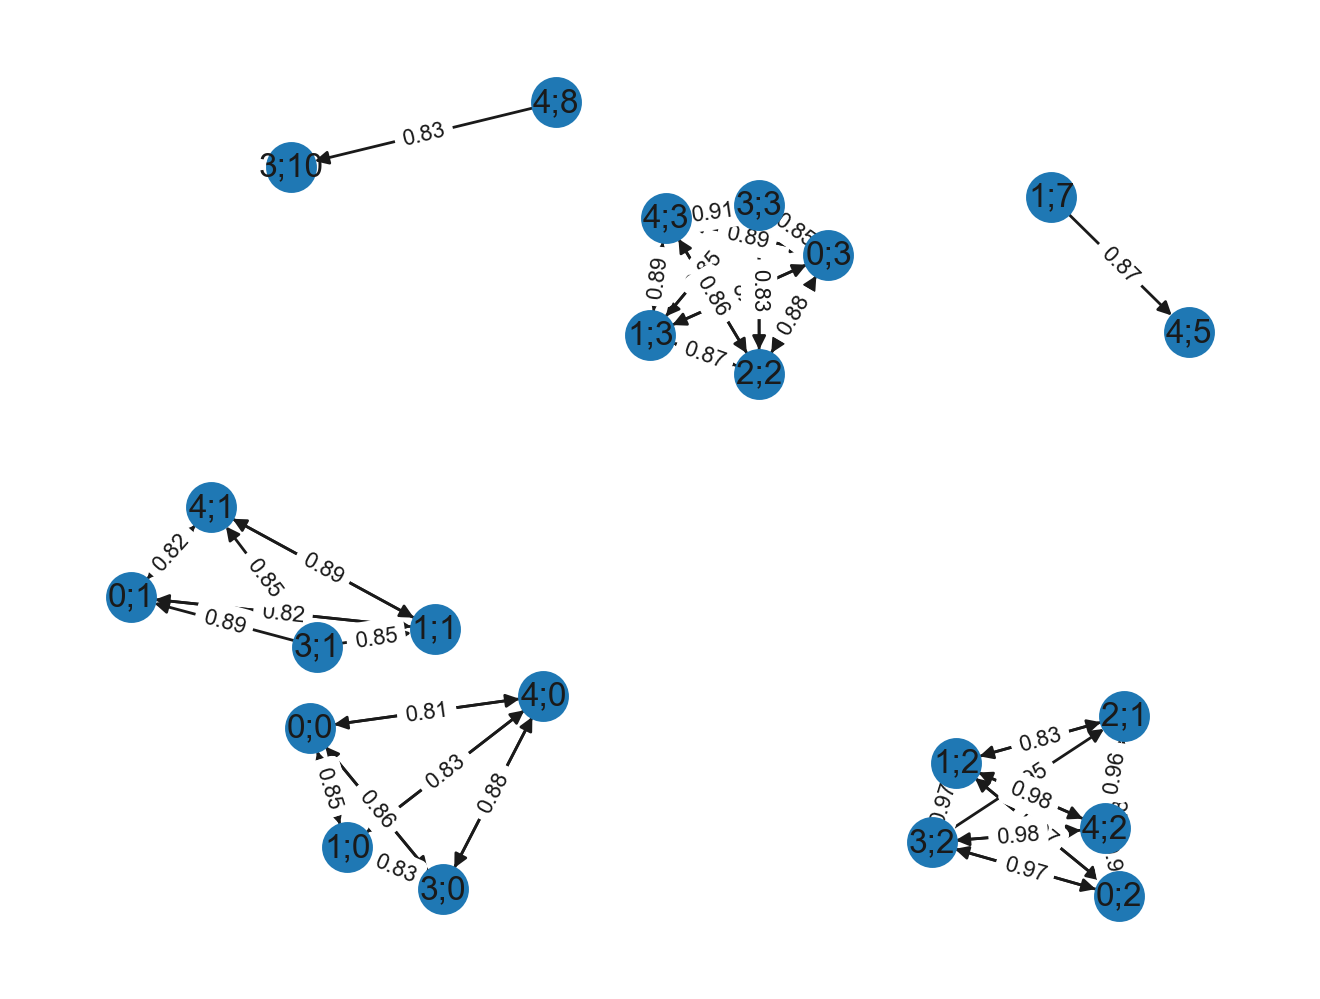

In [87]:
draw_G(G, k=0.5, iterations=30, seed=12)

We see that from the first 10 largest communities, only the first four (communities $0, 1, 2, 3$) are well grouped together. The indexing for communities $2$ and $3$ is not consistent (for example, we map $(0;2)$ to $(1;2)$).

We hypothize that this consistency means that actors in these communities are grouped better than in other ones


In [88]:
from src.utils.actors import Cluster

stable_communities = [
    Cluster(characters, us_movies, communities_US_list[0][0]),
    Cluster(characters, us_movies, communities_US_list[0][1]),
    Cluster(characters, us_movies, communities_US_list[0][2]),
    Cluster(characters, us_movies, communities_US_list[0][3])
]

whole_us_industry = Cluster(characters, us_movies, [a for c in communities_US_list[3] for a in c])

In [89]:
def cluster_most_popular_genres(cluster, top_k=3):
    sorted_genres = sorted(cluster.cluster_genres().items(), key=lambda x: x[1], reverse=True)
    return sorted_genres[:top_k]

Let's find the most popular genres for each of the top communities.
In this section we will say that the film belongs to a cluster if at least half of the cast is in this cluster. This way each film will belong to at most one cluster.

In [90]:
for i, community in enumerate(stable_communities):
    print(f"For community {i} the top-3 genres are: {cluster_most_popular_genres(community)}")

For community 0 the top-3 genres are: [('Drama', 2333), ('Comedy', 2123), ('Thriller', 1363)]
For community 1 the top-3 genres are: [('Comedy', 1826), ('Drama', 1817), ('Thriller', 1032)]
For community 2 the top-3 genres are: [('Drama', 1117), ('Comedy', 859), ('Romance Film', 590)]
For community 3 the top-3 genres are: [('Drama', 1459), ('Comedy', 957), ('Thriller', 923)]


We see that the second one is a bit more about about comedy and the third one has more romance than thriller

In [91]:
us_num_actors_in_movie = dict(us_characters_movies.groupby("WikipediaId").size()) 

for i, community in enumerate(stable_communities):
    top_revenue_movies = community.cluster_movies(select_type="half", num_actors_in_movie=us_num_actors_in_movie).sort_values(by="Revenue", ascending=False)["MovieName"].head(30)
    print(f"For community {i}, the top grossing movies are: {top_revenue_movies.to_list()}")


For community 0, the top grossing movies are: ['Titanic', 'Toy Story 3', 'The Lion King', 'Finding Nemo', 'Jurassic Park', 'Independence Day', 'E.T. the Extra-Terrestrial', 'Up', 'Forrest Gump', 'Men in Black', 'The Simpsons Movie', 'Monsters, Inc.', 'Terminator 2: Judgment Day', 'Ghost', 'Aladdin', 'Toy Story 2', 'Home Alone', 'Pretty Woman', 'Tarzan', 'Mrs. Doubtfire', 'Beauty and the Beast', 'Dances with Wolves', 'Batman', 'The Bodyguard', 'Grease', 'Back to the Future', 'Godzilla', 'The Fugitive', 'Jurassic Park III', 'My Big Fat Greek Wedding']
For community 1, the top grossing movies are: ['Avatar', 'Shrek 2', 'Spider-Man 3', 'Ice Age: Dawn of the Dinosaurs', 'Ice Age: Continental Drift', 'Spider-Man', 'Shrek the Third', 'Spider-Man 2', 'Shrek Forever After', 'The Amazing Spider-Man', "Madagascar 3: Europe's Most Wanted", 'Mission: Impossible – Ghost Protocol', 'The Hunger Games', 'Ice Age: The Meltdown', 'Fast Five', 'Hancock', 'Men in Black 3', 'Iron Man 2', 'Madagascar: Escape

We see that if movies make up a series (like with Shrek, which has Shrek, Shrek 2, Shrek the Third, $\ldots$), then all the movies belong to one cluster. This is expected, because the movies in a series have similar casts.
Example of series from the highest-grossing movies:
- Community 0: Toy Story, Jurassic Park
- Community 1: Shrek, Spider-Man, Ice Age
- Community 2: - (films in this community are a bit more "romantic" as we have seen in the genre analysis and they don't tend to have continuations)
- Community 3: Harry Potter, The Lord of the Rings, The Dark Knight

In [92]:
G = nx.DiGraph()

for i in range(5):
    for j in range(5):
         if i != j:
            mapping = map_communities(i, j)
            TAKE_CONST = 25
            for idx_from, stats_pair in enumerate(mapping[:TAKE_CONST]):
                from_v = f"{i};{idx_from}"
                to_v = f"{j};{stats_pair[0]}"
                if stats_pair[1] > 0.8: # int(idx_from) < TAKE_CONST and int(stats_pair[0]) < TAKE_CONST
                    G.add_edge(from_v, to_v, weight=round(stats_pair[1], 2))

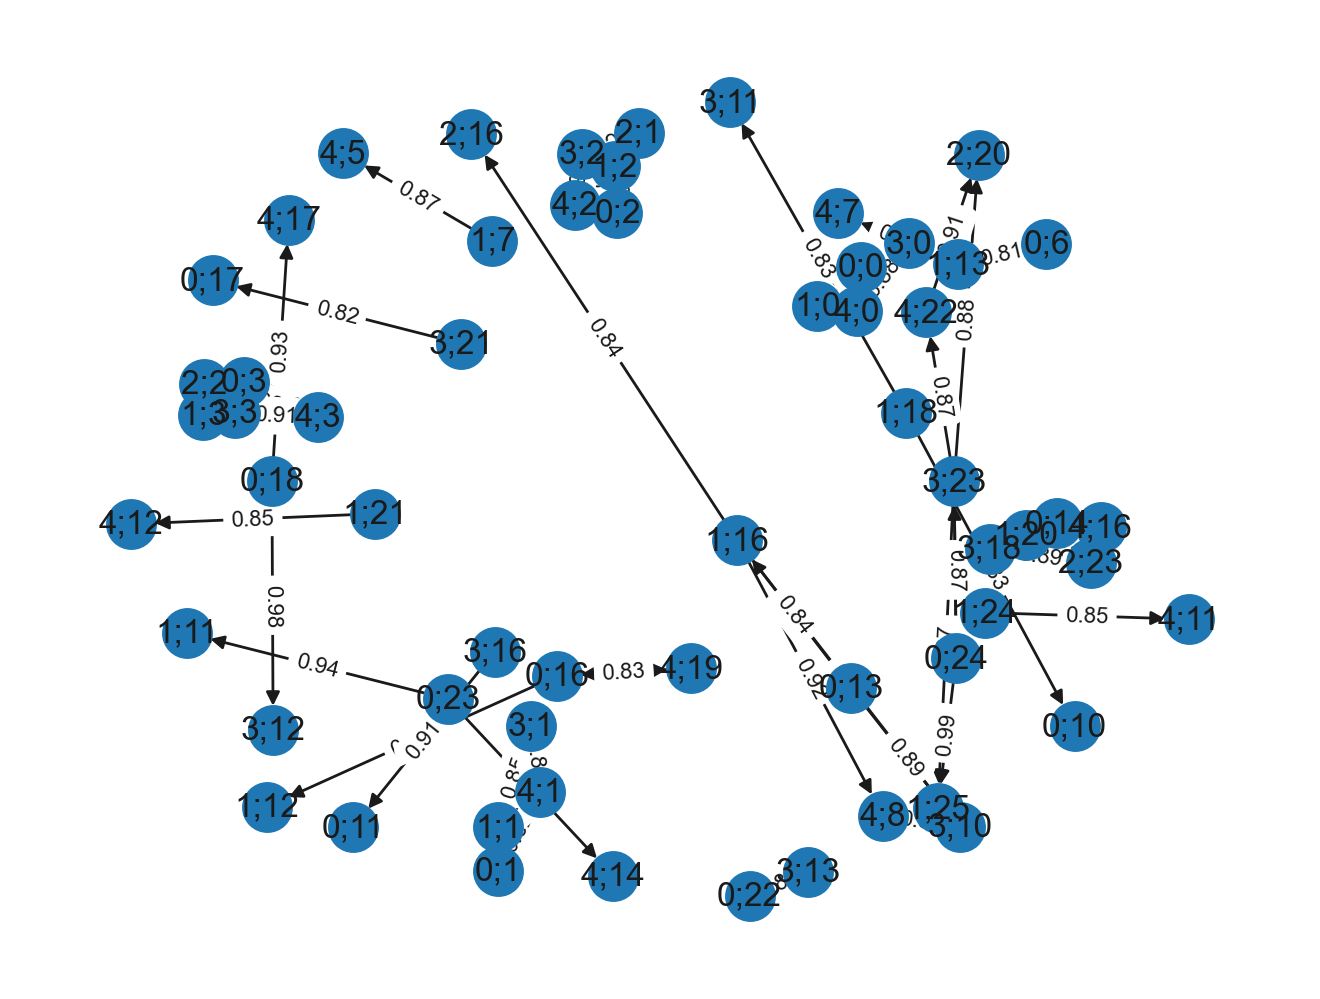

In [93]:
draw_G(G, k=0.2, iterations=30, seed=1)

In [94]:
interesting_clusters = [
    Cluster(characters, us_movies, communities_US_list[0][28]),
    Cluster(characters, us_movies, communities_US_list[0][23]),
    Cluster(characters, us_movies, communities_US_list[0][27]),
    Cluster(characters, us_movies, communities_US_list[0][18]),
]

In [95]:
interesting_clusters[1].cluster_movies(select_type="half", num_actors_in_movie=us_num_actors_in_movie).sort_values(by="Revenue", ascending=False)["MovieName"].head(30)

73924                         The Santa Clause
24838                       The Santa Clause 2
22501    The Santa Clause 3: The Escape Clause
47410                             The Good Son
42282        American Pie Presents: Beta House
74625                                     Zoom
32270                                     Prom
73990                            Away From Her
6618                              How She Move
Name: MovieName, dtype: object

In [97]:
interesting_cluster = interesting_clusters[1]

G_cluster = G_US.subgraph(interesting_cluster.actor_ids)
actor_stats = ActorStats(characters, us_movies)

nx.set_node_attributes(G_cluster, 
                       dict([(actor_id, actor_stats.actor_name(actor_id)) for actor_id in G_cluster.nodes()]),
                       'Name')
_ = katz_centrality(G_cluster)

Wendy Crewson has katz-centrality: 0.161
Tim Allen has katz-centrality: 0.147
Eric Lloyd has katz-centrality: 0.145
Spencer Breslin has katz-centrality: 0.122
Liliana Mumy has katz-centrality: 0.119


Wendy Crewson is actually important to the community, because she played in all of the Santa Clause movies and The Good Son

### Question 5

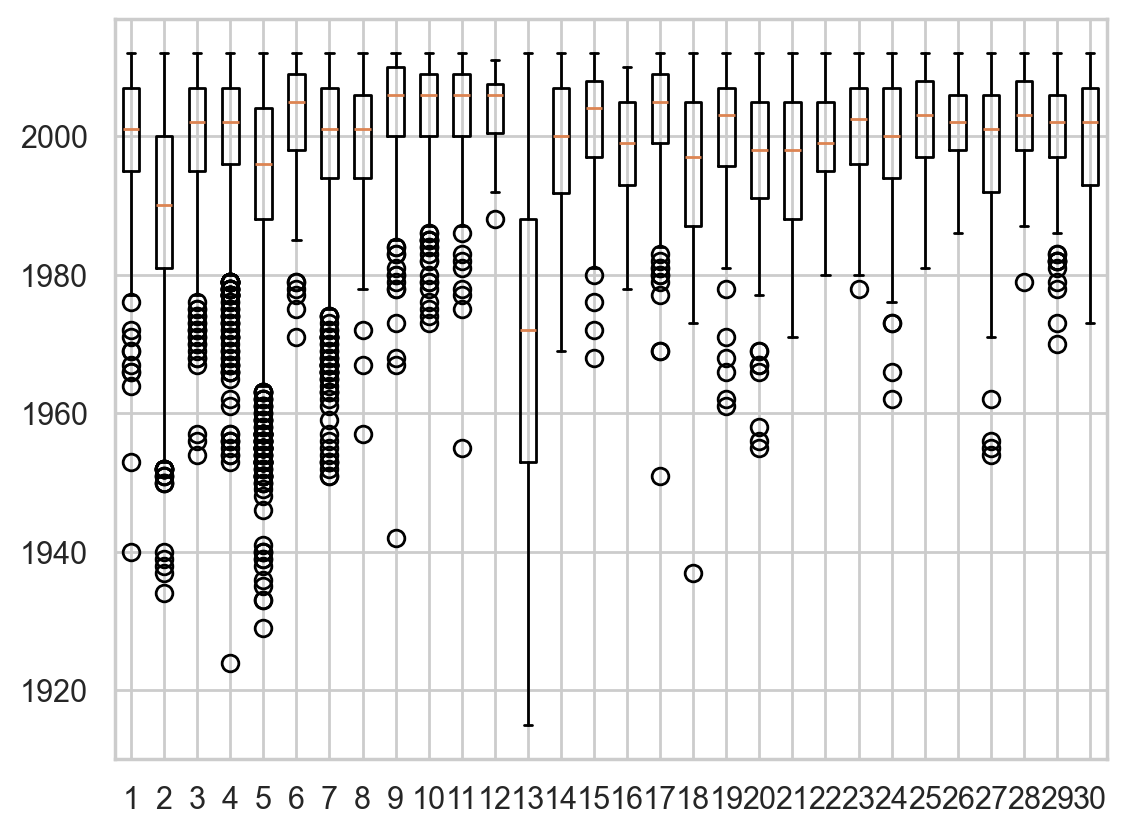

In [99]:
fig, ax = plt.subplots()

means = []
errs = []
cluster_years_list = []
for cluster in graph_stats.clusters:
    cluster_years = cluster.cluster_movies()["ReleaseDate"].apply(lambda x: int(x.year))
    if len(cluster_years) > 50:
        cluster_years_list.append(cluster_years)

ax.boxplot(cluster_years_list)
plt.show()

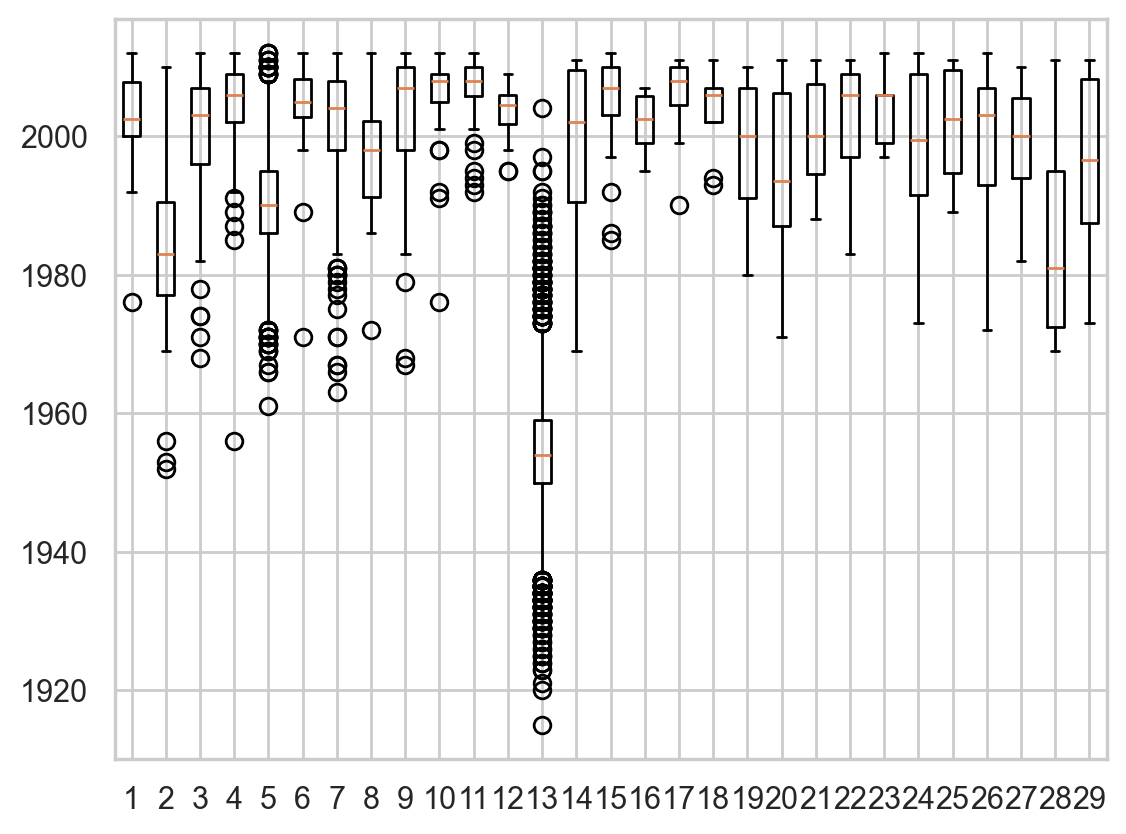

In [101]:
fig, ax = plt.subplots()

means = []
errs = []
cluster_years_list = []
for cluster in graph_stats.clusters:
    cluster_years = cluster.cluster_movies(select_type="half", num_actors_in_movie=us_num_actors_in_movie)["ReleaseDate"].apply(lambda x: int(x.year))
    if len(cluster_years) > 5:
        cluster_years_list.append(cluster_years)

ax.boxplot(cluster_years_list)
plt.show()

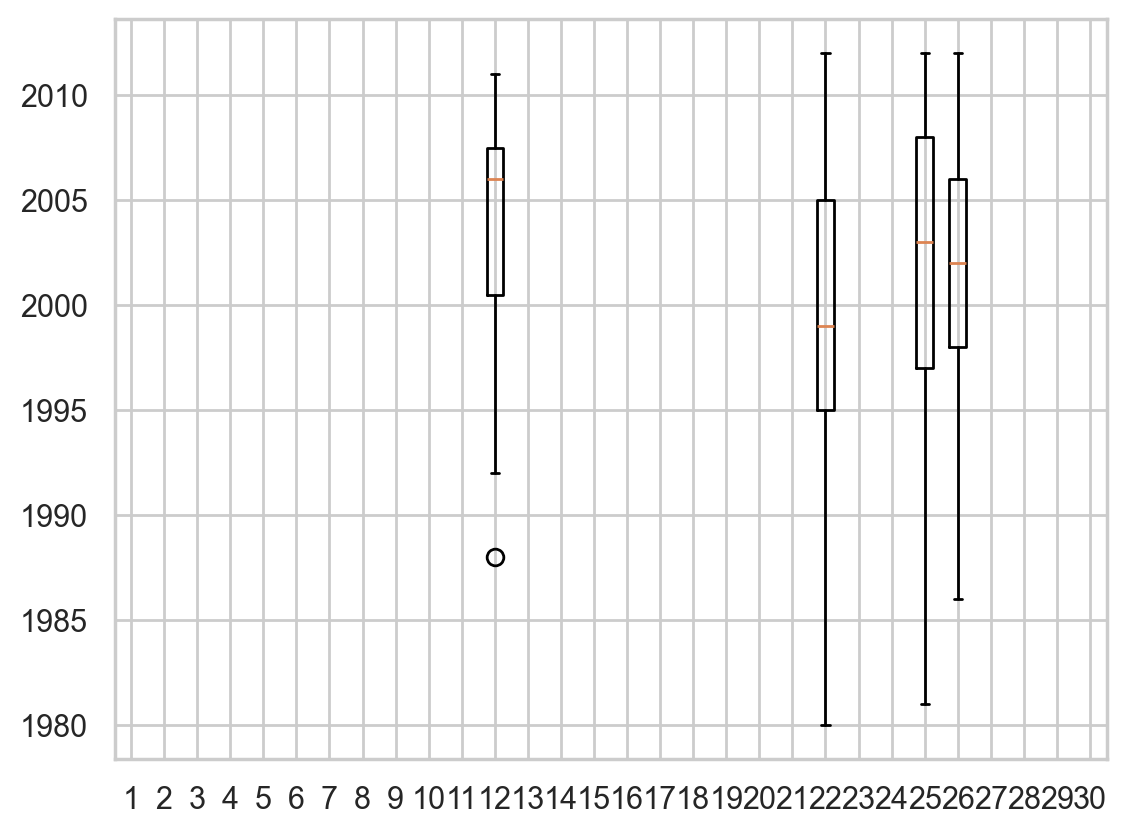

In [102]:
fig, ax = plt.subplots()

means = []
errs = []
cluster_years_list = []
for cluster in graph_stats.clusters:
    cluster_years = cluster.cluster_movies()["ReleaseDate"].apply(lambda x: int(x.year)).where(lambda x: x >= 1980)
    if len(cluster_years) > 50:
        cluster_years_list.append(cluster_years)

ax.boxplot(cluster_years_list)
plt.show()

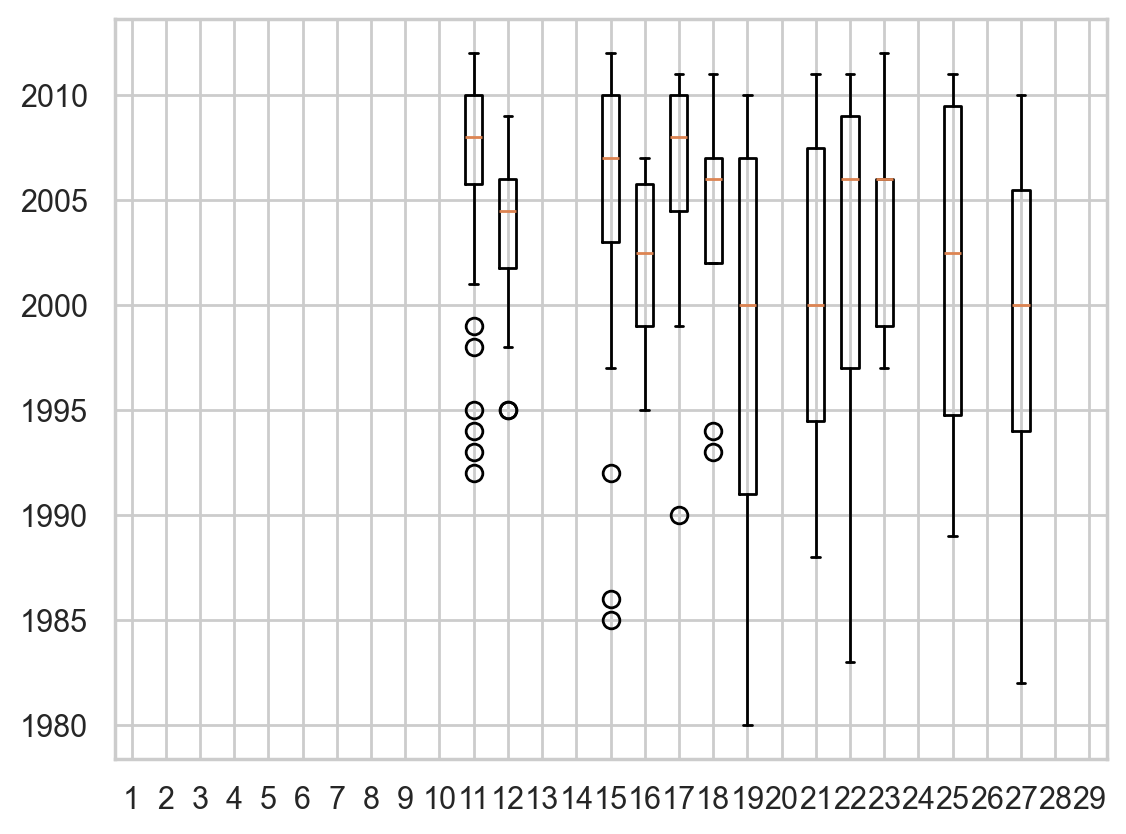

In [103]:
fig, ax = plt.subplots()

means = []
errs = []
cluster_years_list = []
for cluster in graph_stats.clusters:
    cluster_years = cluster.cluster_movies(select_type="half", num_actors_in_movie=us_num_actors_in_movie)["ReleaseDate"].apply(lambda x: int(x.year)).where(lambda x: x >= 1980)
    if len(cluster_years) > 5:
        cluster_years_list.append(cluster_years)
ax.boxplot(cluster_years_list)
plt.show()

### Question 6

#### Imbalances of different languages

In [110]:
movies = load_movies()

In [111]:
def get_len_of_language(movies, country, language):
    countryMovies = filter_by_country(movies, country=country)
    countryMovies = drop_nans(countryMovies, column="Revenue")
    countryMovies = filter_by_language(countryMovies, language=language)
    return len(countryMovies)

In [112]:
countries_langue = {
    'English': ('United States of America', 'English Language'),
    'French' : ('France', 'French Language'),
    'German': ('Germany', 'German Language'),
    'Spanish': ('Spain', 'Spanish Language'),
    'Chinese': ('Italy', 'Italian Language'),
    'Japanise': ('Japan', 'Japanese Language'),
    'Hindi': ('India', 'Hindi Language')  }

In [121]:
storage = {}
for key in countries_langue:
    country, langue = countries_langue[key]
    len_of_countries = get_len_of_language(movies, country, langue)
    storage[key] = len_of_countries

In [122]:
names = list(storage)
vals = [storage[key] for key in storage]
sorted_ind = np.argsort(vals)

In [123]:
sorted_vals = [vals[ind] for ind in reversed(sorted_ind)]
sorted_names = [names[ind] for ind in reversed(sorted_ind)]

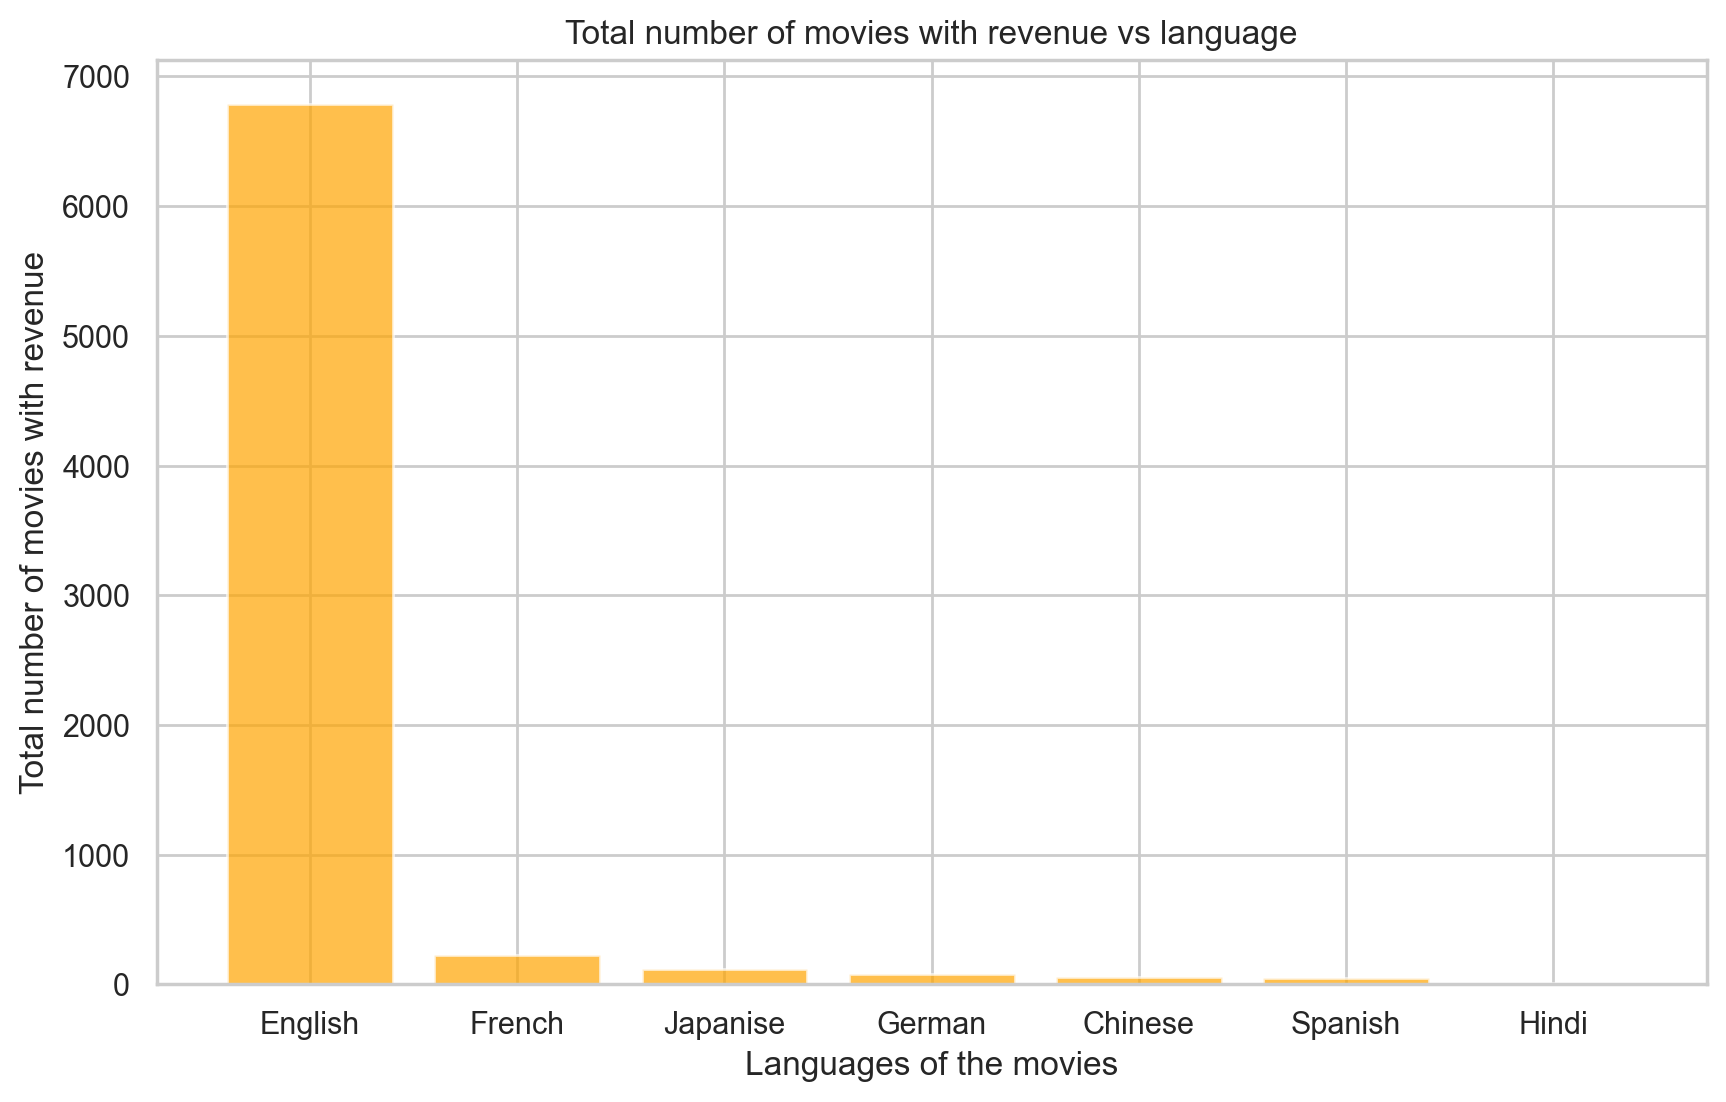

In [124]:
plt.figure(figsize=(10, 6))
plt.bar(sorted_names, sorted_vals, alpha=0.7, color="orange")
plt.title("Total number of movies with revenue vs language")
plt.xlabel("Languages of the movies")
plt.ylabel("Total number of movies with revenue")
plt.grid(True)
plt.show()

Our first idea was to analyse data of movies based on their language and country of origin. However, data about revenue is tiny in all languages, except English. That is why, we have decided to work with genres, rather than with languages of the movies.

#### Different genres (From notebook Question 6a) EDITME

In [125]:
def get_dataset_by_genre(genre):
    movies = load_movies()
    characters = load_characters()


    us_movies = filter_by_country(movies, country="United States of America")
    print("Number of US movies:", us_movies.shape[0])

    us_movies = drop_nans(us_movies, column="Revenue")
    us_movies = drop_nans(us_movies, column="ReleaseDate")
    us_movies = fix_date(us_movies, column="ReleaseDate")
    us_movies  = filter_by_genre(us_movies, genre=genre)
    print("Number of US movies after dropping Nans:", us_movies.shape[0])
    us_movies = filter_by_language(us_movies, language="English Language")

    characters = drop_nans(characters, column="FreebaseActorId")



    us_characters_movies = merge_movies_and_actors(us_movies, characters)
    return us_characters_movies

In [131]:
from src.utils.helpers import read_communities, filter_by_genre

def create_graph(movies_ds):
    G_US = create_graph_from_data(movies_ds)
    print(f"Number of vertices: {len(G_US.nodes)}, number of edges: {len(G_US.edges)}")

    connected_component_sizes = sorted(map(len, get_connected_components(G_US)), reverse=True)
    print(f"Number of components: {len(connected_component_sizes)}, sizes of top-5 components: {connected_component_sizes[:5]} ")

    communities_US = read_communities(G_US, "data/processed/new_communities_US_1.json")
    community_sizes = sorted(map(len, communities_US), reverse=True)
    print(f"Number of communities: {len(communities_US)}, sizes of top-5 communities: {community_sizes[:5]} ")

    
    actor_metrics = (
        movies_ds[['FreebaseActorId']]
        .drop_duplicates()
        .merge(actor_awards[['FreebaseActorId', 'TotalActorAwards']], how='left', on='FreebaseActorId')
        .merge(actor_nominations[['FreebaseActorId', 'TotalActorNominations']], how='left', on='FreebaseActorId')
    )

    actor_metrics['TotalActorAwards'] = actor_metrics['TotalActorAwards'].fillna(0).astype(int)
    actor_metrics['TotalActorNominations'] = actor_metrics['TotalActorNominations'].fillna(0).astype(int)
    return communities_US, actor_metrics

In [132]:
def compute_cluster_metrics_actors(communities, us_characters_movies, actor_metrics):
    """
    Compute metrics for each community based on actor-level data:
    - Total revenue
    - Total actor awards
    - Total actor nominations
    - Number of actors in the community
    """
    cluster_metrics = {}

    for community_id, community_members in enumerate(communities):
        # Filter the actor for community
        community_actor_metrics = actor_metrics[actor_metrics.FreebaseActorId.isin(community_members)]

        # Calculate total awards/nominations
        total_actor_awards = community_actor_metrics['TotalActorAwards'].sum()
        total_actor_nominations = community_actor_metrics['TotalActorNominations'].sum()

        # Calculate total revenue based on movies
        community_movie_ids = us_characters_movies[us_characters_movies.FreebaseActorId.isin(community_members)].FreebaseId.unique()
        total_revenue = us_characters_movies[us_characters_movies.FreebaseId.isin(community_movie_ids)]['Revenue'].sum()
        total_revenue_in_billions = total_revenue / 1_000_000_000

        cluster_metrics[community_id] = {
            "total_revenue": float(f"{total_revenue_in_billions:.2f}"),
            "total_actor_awards": total_actor_awards,
            "total_actor_nominations": total_actor_nominations,
            "num_actors": len(community_members)
        }

    return cluster_metrics


In [133]:
def filter_name_by_dict(ds, storage):
    col = ds['MovieName'].apply(lambda x: x not in storage)
    return ds[col]

In [134]:
comedie_movies = get_dataset_by_genre('Horror')
comedie_storage = set(comedie_movies.MovieName)
drama_movies = get_dataset_by_genre('Drama')
drama_storage = set(drama_movies.MovieName)

Number of US movies: 34408
Number of US movies after dropping Nans: 663
Number of US movies: 34408
Number of US movies after dropping Nans: 3429


In [135]:
comedie_movies = filter_name_by_dict(comedie_movies, drama_storage)
drama_movies = filter_name_by_dict(drama_movies, comedie_storage)

In [136]:
comedie_communties, comedie_actor_metrics = create_graph(comedie_movies)
comedie_cluster_metrics = compute_cluster_metrics_actors(comedie_communties, comedie_movies, comedie_actor_metrics)

Number of vertices: 4964, number of edges: 45006
Number of components: 32, sizes of top-5 components: [4685, 31, 21, 17, 16] 
Number of communities: 133, sizes of top-5 communities: [6332, 5748, 4505, 3979, 1655] 


In [137]:
total_comedie_revenues = [metrics["total_revenue"] for metrics in comedie_cluster_metrics.values()]
total_comedie_num_actors = [metrics["num_actors"] for metrics in comedie_cluster_metrics.values()]
total_comedie_actor_awards = [metrics["total_actor_awards"] for metrics in comedie_cluster_metrics.values()]

In [138]:
drama_communties, drama_actor_metrics = create_graph(drama_movies)
drama_cluster_metrics = compute_cluster_metrics_actors(drama_communties, drama_movies, drama_actor_metrics)

Number of vertices: 19579, number of edges: 319847
Number of components: 27, sizes of top-5 components: [19359, 18, 17, 16, 14] 
Number of communities: 133, sizes of top-5 communities: [6332, 5748, 4505, 3979, 1655] 


In [139]:
total_drama_revenues = [metrics["total_revenue"] for metrics in drama_cluster_metrics.values()]
total_drama_num_actors = [metrics["num_actors"] for metrics in drama_cluster_metrics.values()]
total_drama_actor_awards = [metrics["total_actor_awards"] for metrics in drama_cluster_metrics.values()]

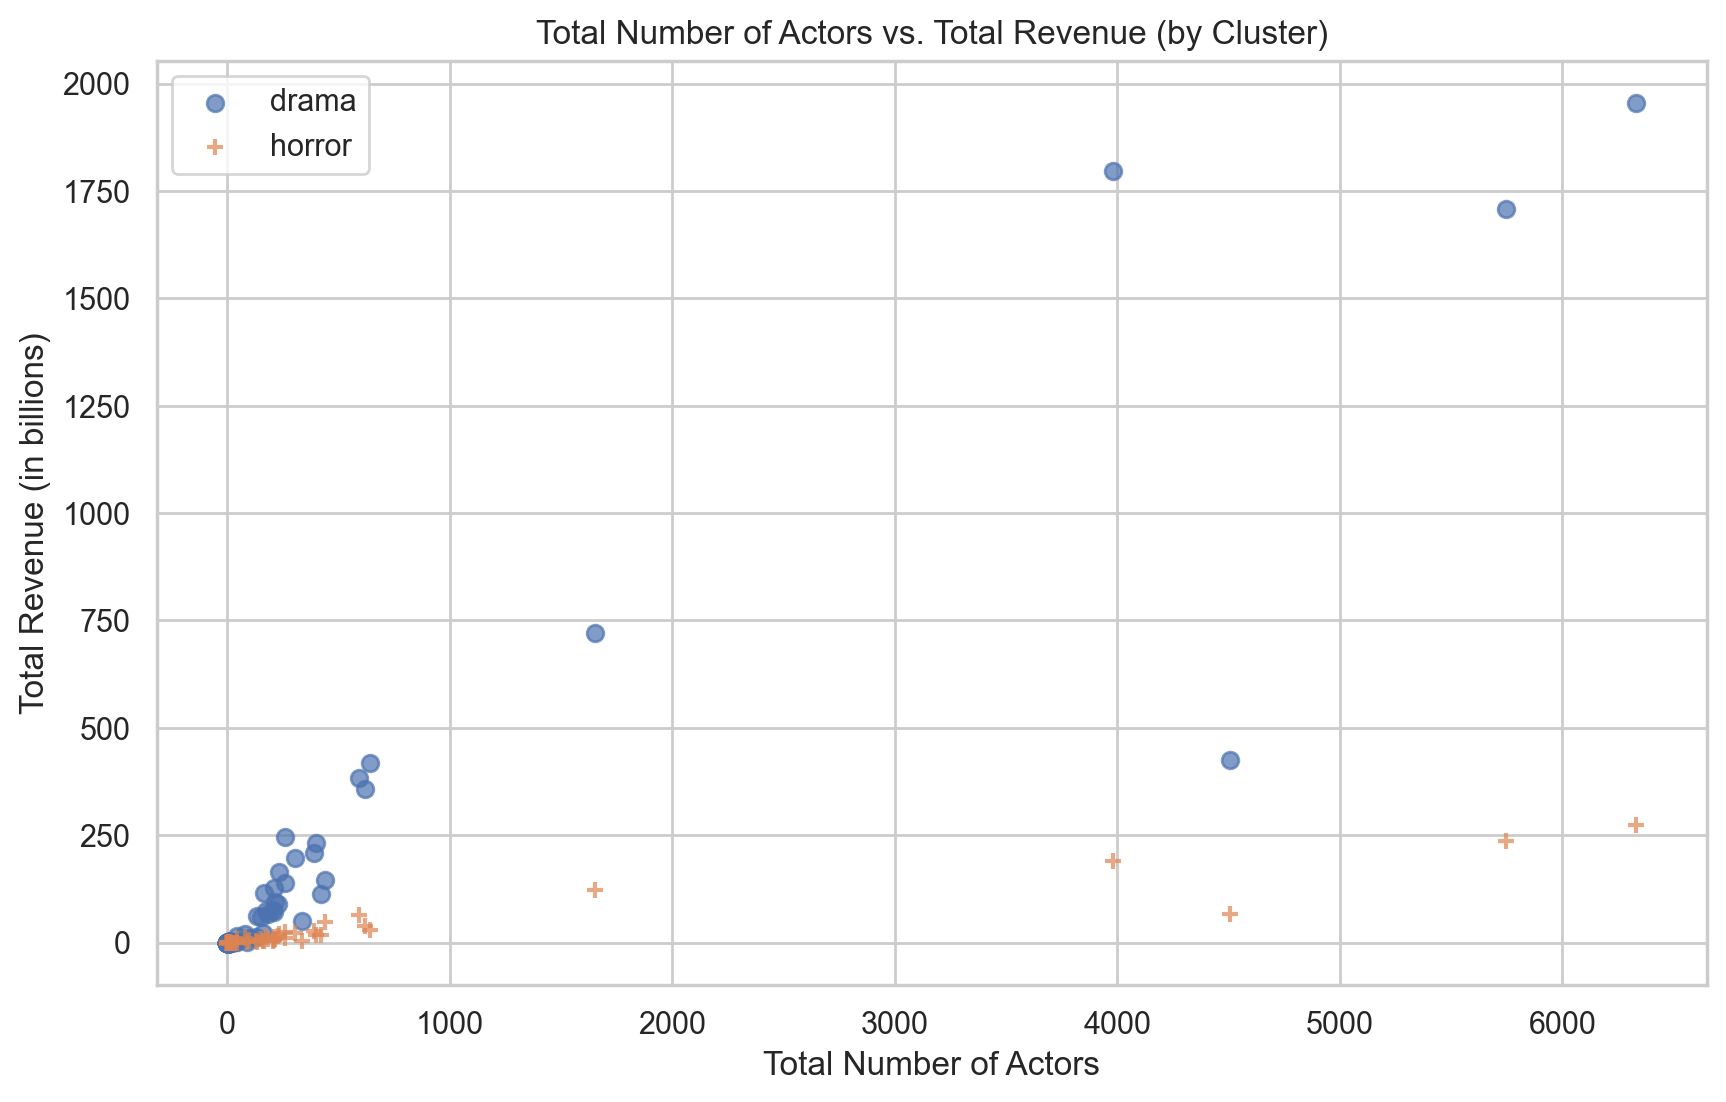

In [140]:
plt.figure(figsize=(10, 6))
plt.scatter(total_drama_num_actors, total_drama_revenues, alpha=0.7, marker='o', label='drama')
plt.scatter(total_comedie_num_actors, total_comedie_revenues, alpha=0.7, marker='+', label='horror')

plt.title("Total Number of Actors vs. Total Revenue (by Cluster)")
plt.xlabel("Total Number of Actors")
plt.ylabel("Total Revenue (in billions)")
plt.grid(True)
plt.legend()
plt.show()